# Model experiments

In this notebook we will experiment with different models and different fitting and we will compare the results.

In [2]:
# Basic imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.stats.stattools import durbin_watson
sns.set_style("darkgrid")
sns.set_palette("coolwarm_r")
from scipy import signal

from scipy.stats import normaltest
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import statsmodels.api as sm
import pymannkendall as mk

from pandas.plotting import autocorrelation_plot


from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from pmdarima import auto_arima                        
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import TimeSeriesSplit

from statsmodels.graphics.tsaplots import plot_predict

import itertools
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
path = "../../data_postprocess/data_nuevo/"
path_bruto = "../../data/"


In [3]:
def plot_zoom(model_fit, df, df_test,n, var):
    plt.figure(figsize=(16, 10))
    predictions = model_fit.predict(n,len(df_test)+n-1, dynamic=True)
    predictions.index = df_test.index
    df.iloc[-(df_test.shape[0]+1000):,:][var].plot(label='true values')
    predictions.plot(label='predicted values', color='cornflowerblue')
    plt.legend()



In [4]:
#We create a function because we are going to use this two cells in all the models that we train

def metrics(model_fit, df_test, df_train):
    print("TRAIN SET METRICS")
    train_forecast = model_fit.predict(start=df_train.index[0], end=df_train.index[-1])
    mae = mean_absolute_error(df_train, train_forecast)
    mape = mean_absolute_percentage_error(df_train, train_forecast)
    rmse = np.sqrt(mean_squared_error(df_train, train_forecast))

    print(f'mae: {mae}')
    print(f'mape: {mape}')
    print(f'rmse: {rmse}')

    print("TEST SET METRICS")
    test_forecast = model_fit.forecast(len(df_test))
    mae = mean_absolute_error(df_test, test_forecast)
    mape = mean_absolute_percentage_error(df_test, test_forecast)
    rmse = np.sqrt(mean_squared_error(df_test, test_forecast))

    print(f'mae: {mae}')
    print(f'mape: {mape}')
    print(f'rmse: {rmse}')


In [5]:
def metrics2(test_forecast, df_test, text="TRAIN"):
    

    print(text+" SET METRICS")
    mae = mean_absolute_error(df_test, test_forecast)
    mape = mean_absolute_percentage_error(df_test, test_forecast)
    rmse = np.sqrt(mean_squared_error(df_test, test_forecast))

    print(f'mae: {mae}')
    print(f'mape: {mape}')
    print(f'rmse: {rmse}')

In [6]:
def residual_analysis(residuals, lags=40, test_lags = [1, 10], alpha=0.05, title=""):
    """
    Generate various plots and tests to analyze the residuals.

    Parameters:
        residuals (array-like): Residuals to analyze
        lags (int): Number of lags to include in the autocorrelation and partial autocorrelation plots
        alpha (float): Significance level for the Ljung-Box test

    Returns:
        None
    """

    # Create common subplot for all plots
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    fig.subplots_adjust(hspace=0.5)

    # Autocorrelation plot with confidence intervals
    sm.graphics.tsa.plot_acf(residuals, lags=lags, ax=axes[0, 0], alpha=alpha)
    axes[0, 0].set(title="Autocorrelation Plot",
                  xlabel="Lag", ylabel="Autocorrelation")

    # Partial autocorrelation plot
    sm.graphics.tsa.plot_pacf(residuals, lags=lags, ax=axes[0, 1])
    axes[0, 1].set(title="Partial Autocorrelation Plot", xlabel="Lag", ylabel="Partial Autocorrelation")

    # Q-Q plot
    sm.graphics.qqplot(residuals, line='s', ax=axes[1, 0])
    axes[1, 0].set(title="Q-Q Plot", xlabel="Theoretical Quantiles", ylabel="Sample Quantiles")

    # Histogram plot with kde line
    sns.histplot(residuals, bins=30, kde=True)
    axes[1, 1].set(title="Histogram with KDE Line", xlabel="Residuals", ylabel="Frequency")
    plt.suptitle("Residual analysis for: " + title)
    plt.show()

    # Normality test
    pvalue = normaltest(residuals)[1]
    if pvalue < alpha:
        print("The residuals do not follow a normal distribution (p-value = {:.20f}, alpha = {})".format(pvalue, alpha))
    else:
        print("The residuals follow a normal distribution (p-value = {:.20f}, alpha = {})".format(pvalue, alpha))

    # Ljung-Box test
    test_results = acorr_ljungbox(residuals, lags=test_lags, auto_lag=True)
    pvalues = test_results['lb_pvalue']
    if np.any(pvalues < alpha):
        print("The residuals are autocorrelated (some p-values < alpha = {:.10f})".format(alpha))
        print(test_results)
    else:
        print("The residuals are not autocorrelated (all p-values >= alpha = {:.10f})".format(alpha))

    dw = durbin_watson(residuals)
    print("Durbin Watson: ", dw)
    if (dw >= 1.5 and dw<=2.5):
        print("No autocorrelation")
    else:
        print("Autocorrelation")


## 1. Models on full variable

We will start by fitting a model on one variable, which is the hvac energy use in north wing (hvac_N). In this first attempt, we will have data from September 2018 until February 2020. 

In [7]:
# Importamos csv
energy_use = pd.read_csv(path+'ele_def.csv')
#We change the date column into datetime format
energy_use['date']= pd.to_datetime(energy_use['date'])
energy_use.set_index('date', inplace=True)
energy_use= energy_use.clip(lower=0.01)


In [8]:
energy_use['hvac']=energy_use['hvac_N']+energy_use['hvac_S']

The variable we will study is 'hvac' (air conditioning in both wings).

In [9]:
var = 'hvac'

Text(0.5, 1.0, 'Energía utilizada en el ala sur')

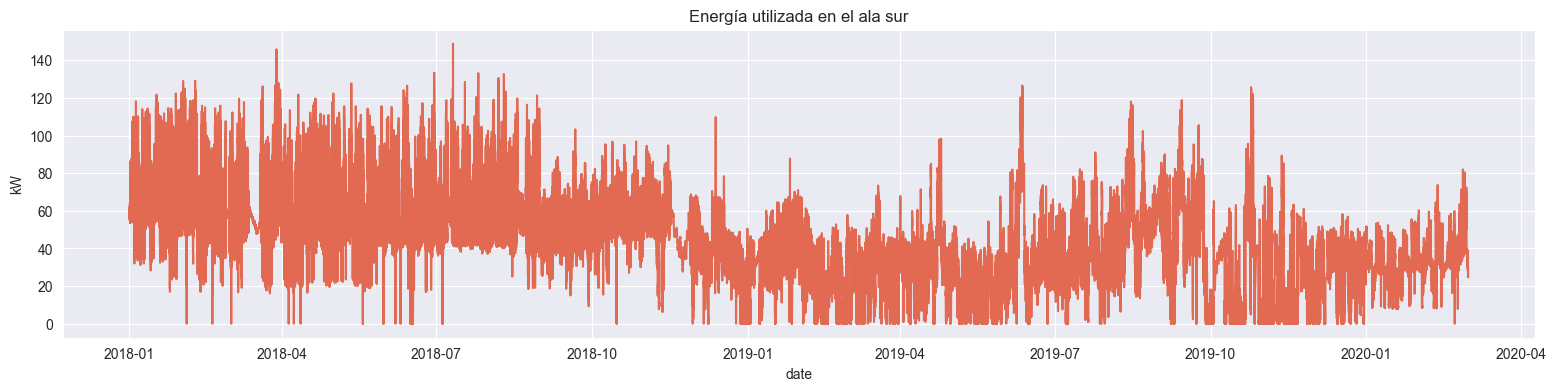

In [10]:
plt.figure(figsize=(19,4))
sns.lineplot(x =energy_use.index , y=energy_use[var])
plt.ylabel('kW')

plt.title('Energía utilizada en el ala sur')

In [11]:
# We crop until March 2020, since it's the expected normal use (covid effect)

energy_use=energy_use[energy_use.index < '2020-03-01 00:00:00']


In [12]:
energy_use = energy_use.resample('15T').mean()


In [13]:
#Split into train and test:

df_train = energy_use.iloc[:-2000,:][var]
df_test = energy_use.iloc[-2000:, :][var]




### ARIMA 

We will fit a very basic ARIMA model into this variable, and we will study its behaviour. Since we have seasonality in our data, we will also use SARIMA and compare the results of fitting both models.
For this model, we have to decide the value of the main parameters:
- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.




In [13]:
import warnings
warnings.filterwarnings("ignore")

First, we will implement a model that has as a train set 75% of the whole set, and forecasts the next 25% of the samples in one single take.


In [14]:
model_arima_inicial = ARIMA(df_train, order =(1,3,2))
model_arima_inicial_fit = model_arima_inicial.fit()
print(model_arima_inicial_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                 hvac_N   No. Observations:                73836
Model:                 ARIMA(1, 3, 2)   Log Likelihood             -243013.839
Date:                Tue, 07 Mar 2023   AIC                         486035.678
Time:                        15:38:29   BIC                         486072.517
Sample:                    01-01-2018   HQIC                        486047.012
                         - 02-09-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4341      0.002   -219.405      0.000      -0.438      -0.430
ma.L1         -1.9685      0.001  -2532.255      0.000      -1.970      -1.967
ma.L2          0.9747      0.001   1256.942      0.0

Next, we will plot the residuals (necessary to check if there are patterns):


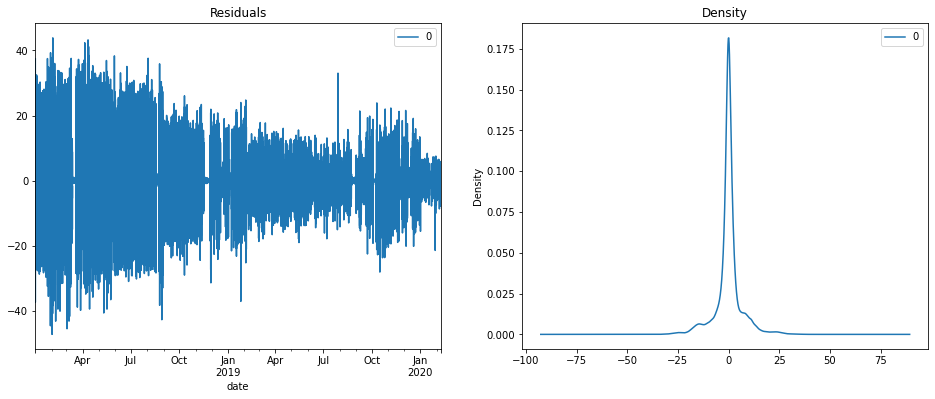

In [16]:
# Plot residual errors
residuals = pd.DataFrame(model_arima_inicial_fit.resid)
fig, ax= plt.subplots(nrows=1,ncols=2, figsize=(16,6) )
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

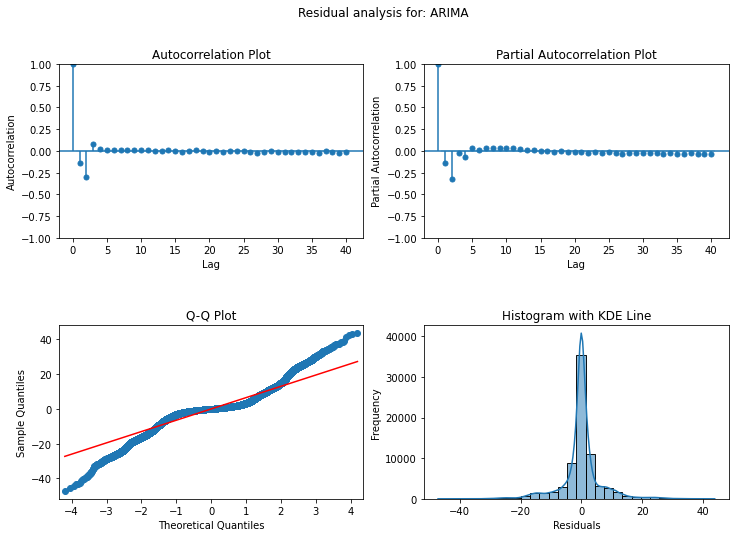

The residuals do not follow a normal distribution (p-value = 0.00000000000000000000, alpha = 0.05)
The residuals are autocorrelated (some p-values < alpha = 0.0500000000)
           lb_stat  lb_pvalue
1      1513.960894        0.0
2      7995.144784        0.0
3      8518.173539        0.0
4      8570.624828        0.0
5      8580.801729        0.0
...            ...        ...
8068  30650.510008        0.0
8069  30652.170478        0.0
8070  30661.642381        0.0
8071  30664.273859        0.0
8072  30664.301378        0.0

[8072 rows x 2 columns]
Durbin Watson:  2.285933368058768
No autocorrelation


In [19]:
residual_analysis(model_arima_inicial_fit.resid, title="ARIMA")

We want to plot the predictions of the model starting for the test set. We will also check if a dynamic forecasting works better than static one.

In [23]:
df_test

date
2020-02-09 04:00:00    8.296667
2020-02-09 04:15:00    9.098000
2020-02-09 04:30:00    8.350000
2020-02-09 04:45:00    8.533333
2020-02-09 05:00:00    8.725714
                         ...   
2020-02-29 22:45:00    8.618000
2020-02-29 23:00:00    8.316667
2020-02-29 23:15:00    8.560000
2020-02-29 23:30:00    8.020000
2020-02-29 23:45:00    8.022500
Freq: 15T, Name: hvac_N, Length: 2000, dtype: float64

In [21]:
energy_use.iloc[-(df_test.shape[0]-1000):,:]

mels_S     lig_S    mels_N     hvac_N     hvac_S
date                                                                   
2020-02-19 14:00:00  2.800000  2.911111  4.486029   9.573750  22.726667
2020-02-19 14:15:00  2.700000  2.900000  4.933986  10.327143  25.527778
2020-02-19 14:30:00  2.625000  3.400000  4.901590   9.962727  23.973684
2020-02-19 14:45:00  4.198333  3.585714  5.194832   9.727143  23.070000
2020-02-19 15:00:00  5.366667  3.600000  5.358859   9.615000  22.841579
...                       ...       ...       ...        ...        ...
2020-02-29 22:45:00  0.700000  0.020000  1.225181   8.618000  16.100000
2020-02-29 23:00:00  0.733333  0.010000  1.623994   8.316667  21.100000
2020-02-29 23:15:00  0.660000  0.010000  1.222089   8.560000  19.918000
2020-02-29 23:30:00  0.625000  0.010000  1.399116   8.020000  21.700000
2020-02-29 23:45:00  0.825000  0.010000  1.574987   8.022500  22.083333

[1000 rows x 5 columns]

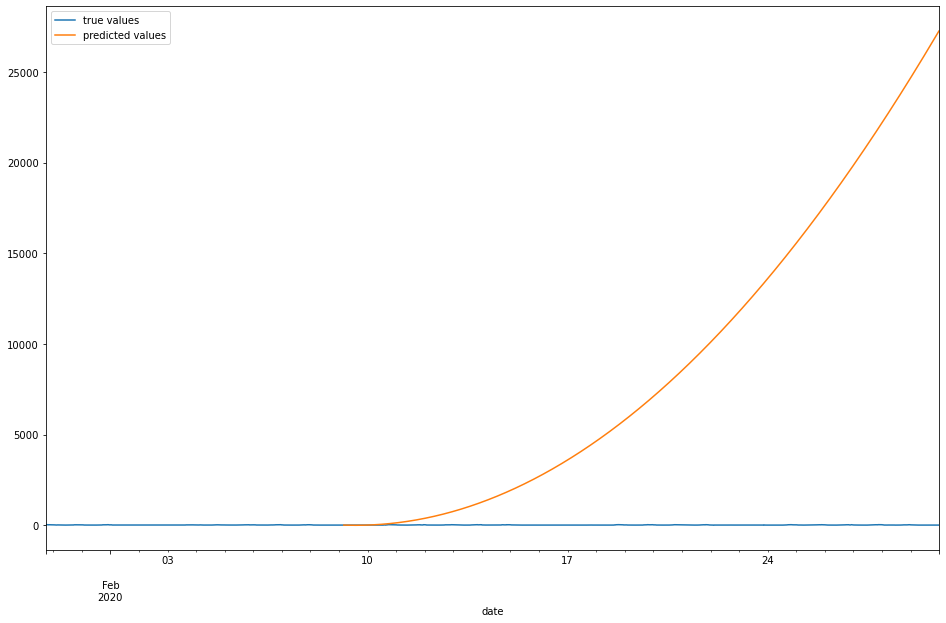

In [47]:
plot_zoom(model_arima_inicial_fit, energy_use, df_test,len(df_train), var)

We see that the model is not performing well. This can be due to the current train-test split. We are going to add some more samples to the test set so that the end of the train set doesn't end in the constant line that we can see in the plot. 

                               SARIMAX Results                                
Dep. Variable:                 hvac_N   No. Observations:                73336
Model:                 ARIMA(1, 3, 2)   Log Likelihood             -241598.934
Date:                Tue, 07 Mar 2023   AIC                         483205.867
Time:                        16:06:41   BIC                         483242.678
Sample:                    01-01-2018   HQIC                        483217.197
                         - 02-03-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4343      0.002   -218.127      0.000      -0.438      -0.430
ma.L1         -1.9685      0.001  -2520.199      0.000      -1.970      -1.967
ma.L2          0.9747      0.001   1250.950      0.0

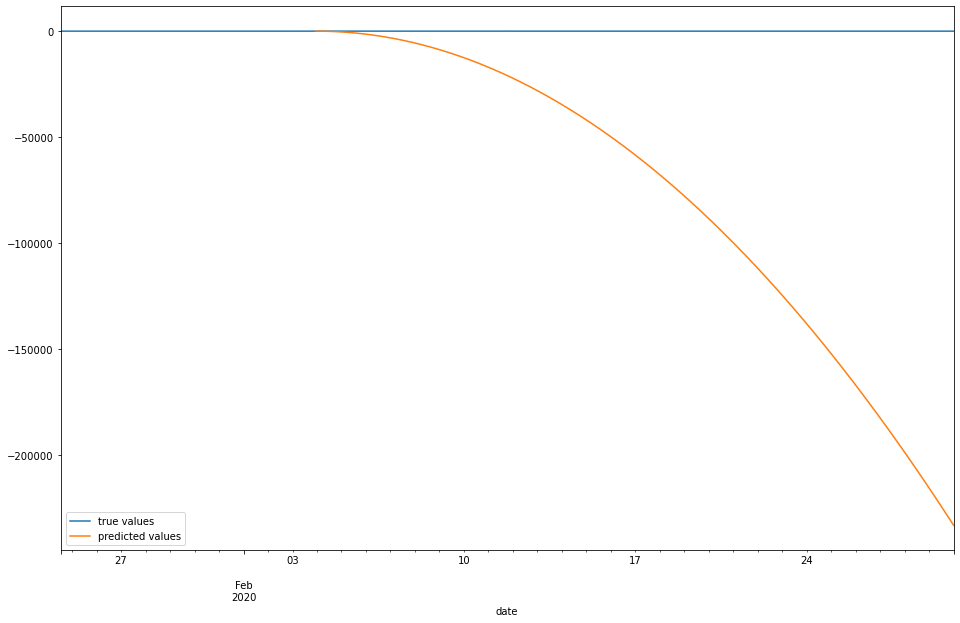

In [48]:
#Split into train and test:

df_train_2 = energy_use.iloc[:-2500,:][var]
df_test_2 = energy_use.iloc[-2500:, :][var]

model_arima_2 = ARIMA(df_train_2, order =(1,3,2))
model_arima_2_fit = model_arima_2.fit()
print(model_arima_2_fit.summary())

plot_zoom(model_arima_2_fit,energy_use, df_test_2,len(df_train_2), var)

The problem was not the split, the behaviour of the model is still very bad.

In [29]:
start = df_train_2.index[50000]
end = df_train_2.index[-1]


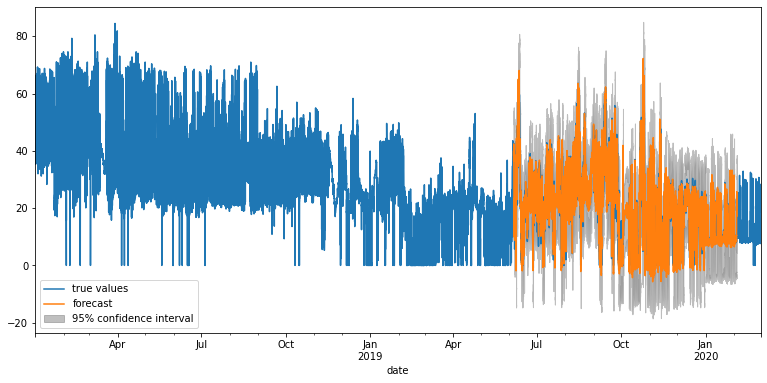

In [30]:
# Actual vs Fitte
fig, ax = plt.subplots(figsize=(13,6))

ax = energy_use[var].plot(label ='true values', ax=ax)

fig = plot_predict(model_arima_2_fit, start = start, end = end, ax = ax)
#ax.set_xlim(['2019-01', '2019-02'])
plt.show()

The model is overfitting our training data. We are going to try to use a bigger test set:

                               SARIMAX Results                                
Dep. Variable:                 hvac_N   No. Observations:                65836
Model:                 ARIMA(1, 3, 2)   Log Likelihood             -219854.568
Date:                Tue, 07 Mar 2023   AIC                         439717.136
Time:                        16:07:06   BIC                         439753.516
Sample:                    01-01-2018   HQIC                        439728.388
                         - 11-17-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4382      0.002   -200.725      0.000      -0.443      -0.434
ma.L1         -1.9698      0.001  -2443.631      0.000      -1.971      -1.968
ma.L2          0.9762      0.001   1213.763      0.0

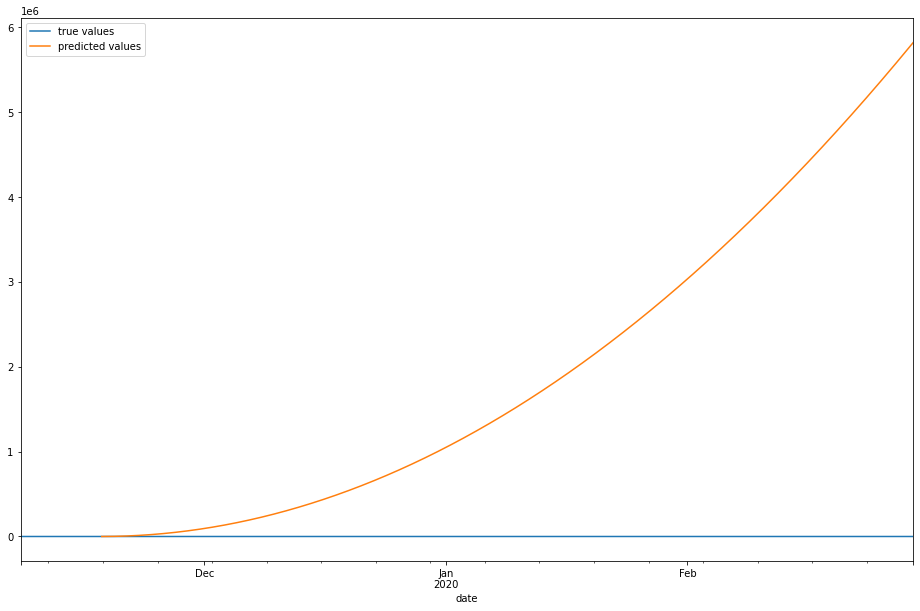

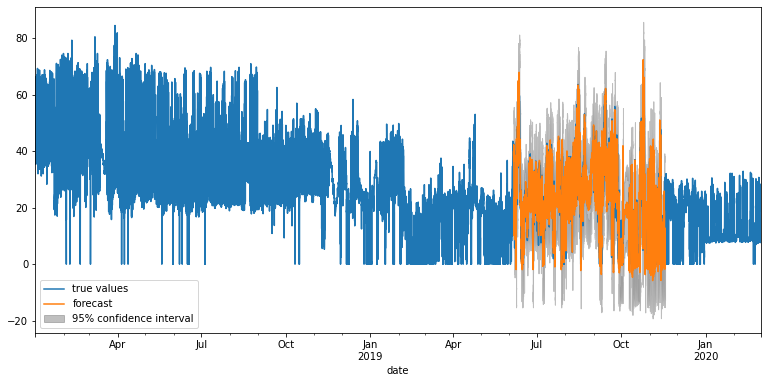

In [49]:
#Split into train and test:

df_train_3 = energy_use.iloc[:-10000,:][var]
df_test_3 = energy_use.iloc[-10000:, :][var]

model_arima_3 = ARIMA(df_train_3, order =(1,3,2))
model_arima_3_fit = model_arima_3.fit()
print(model_arima_3_fit.summary())

plot_zoom(model_arima_3_fit,energy_use, df_test_3,len(df_train_3), var)



start = df_train_3.index[50000]
end = df_train_3.index[-1]

# Actual vs Fitte
fig, ax = plt.subplots(figsize=(13,6))

ax = energy_use[var].plot(label ='true values', ax=ax)

fig = plot_predict(model_arima_3_fit, start = start, end = end, ax = ax)
#ax.set_xlim(['2019-01', '2019-02'])
plt.show()

##### Evaluation metrics

We will check the train and test evaluation metrics: MAE (Mean Absolute Error), MAPE (Mean Absolute Percentage Error), and RMSE (Root Mean Squared Error). As we have seen in previous plots, the behaviour in train and test sets is very different:

In [34]:
print("TRAIN SET METRICS")
train_forecast = model_arima_inicial_fit.predict(start=df_train.index[0], end=df_train.index[-1])
mae = mean_absolute_error(df_train, train_forecast)
mape = mean_absolute_percentage_error(df_train, train_forecast)
rmse = np.sqrt(mean_squared_error(df_train, train_forecast))

print(f'mae: {mae}')
print(f'mape: {mape}')
print(f'rmse: {rmse}')

TRAIN SET METRICS
mae: 3.8120137570508836
mape: 10.721432545733768
rmse: 6.506595690317276


In [35]:
print("TEST SET METRICS")
test_forecast = model_arima_inicial_fit.forecast(len(df_test))
mae = mean_absolute_error(df_test, test_forecast)
mape = mean_absolute_percentage_error(df_test, test_forecast)
rmse = np.sqrt(mean_squared_error(df_test, test_forecast))

print(f'mae: {mae}')
print(f'mape: {mape}')
print(f'rmse: {rmse}')

TEST SET METRICS
mae: 8893.065800033783
mape: 2016.2991608232564
rmse: 12061.099481279167


Clearly, we have overfitting, this means that the model is not able to correctly predict outside of the training set.

#### Parameter tuning
Even if we didn't acheive great results with ARIMA, we will try to tune the parameters, comparing models with the AIC and BIC metrics:

In [36]:
# Create empty list to store search results
order_aic_bic=[]

# Loop over p values from 0-2
for p in range(0, 3):

  for d in range(0,3):
  # Loop over q values from 0-2
    for q in range(0, 3):
        print("Model: \np=", p,"\nd=", d, "\nq=", q)
      	# create and fit ARMA(p,q) model
        model = ARIMA(df_train_grouped_grouped, order=(p,d,q))
        results = model.fit()
        
        # Append order and results tuple
        order_aic_bic.append((p, d, q, results.aic, results.bic))

Model: 
p= 0 
d= 0 
q= 0
Model: 
p= 0 
d= 0 
q= 1
Model: 
p= 0 
d= 0 
q= 2
Model: 
p= 0 
d= 1 
q= 0
Model: 
p= 0 
d= 1 
q= 1
Model: 
p= 0 
d= 1 
q= 2
Model: 
p= 0 
d= 2 
q= 0
Model: 
p= 0 
d= 2 
q= 1
Model: 
p= 0 
d= 2 
q= 2
Model: 
p= 1 
d= 0 
q= 0
Model: 
p= 1 
d= 0 
q= 1
Model: 
p= 1 
d= 0 
q= 2
Model: 
p= 1 
d= 1 
q= 0
Model: 
p= 1 
d= 1 
q= 1
Model: 
p= 1 
d= 1 
q= 2
Model: 
p= 1 
d= 2 
q= 0
Model: 
p= 1 
d= 2 
q= 1
Model: 
p= 1 
d= 2 
q= 2
Model: 
p= 2 
d= 0 
q= 0
Model: 
p= 2 
d= 0 
q= 1
Model: 
p= 2 
d= 0 
q= 2
Model: 
p= 2 
d= 1 
q= 0
Model: 
p= 2 
d= 1 
q= 1
Model: 
p= 2 
d= 1 
q= 2
Model: 
p= 2 
d= 2 
q= 0
Model: 
p= 2 
d= 2 
q= 1
Model: 
p= 2 
d= 2 
q= 2


In [37]:
# Construct DataFrame from order_aic_bic
order_df = pd.DataFrame(order_aic_bic, 
                        columns=['p','d','q','AIC','BIC'])

# Print order_df in order of increasing AIC
print(order_df.sort_values(by='AIC', ascending=True))



    p  d  q            AIC            BIC
23  2  1  2  467347.503918  467393.551859
22  2  1  1  467422.322562  467459.160914
20  2  0  2  467428.178736  467483.436346
26  2  2  2  467434.868760  467480.916633
11  1  0  2  467655.058233  467701.106241
19  2  0  1  467655.658095  467701.706104
10  1  0  1  467655.764144  467692.602551
14  1  1  2  467694.437817  467731.276170
4   0  1  1  467931.105171  467949.524347
5   0  1  2  467932.637613  467960.266377
13  1  1  1  467932.736202  467960.364967
17  1  2  2  467943.622318  467980.460616
8   0  2  2  467945.672241  467973.300965
21  2  1  0  471856.158749  471883.787514
25  2  2  1  471865.582698  471902.420996
18  2  0  0  480138.904171  480175.742578
12  1  1  0  482034.447649  482052.866826
16  1  2  1  482046.138996  482073.767720
9   1  0  0  493784.376710  493812.005515
3   0  1  0  498551.235445  498560.445033
7   0  2  1  498559.719758  498578.138907
24  2  2  0  515659.186170  515686.814893
2   0  0  2  533188.775153  533225

In [39]:
print(order_df.sort_values(by='BIC', ascending=True))


    p  d  q            AIC            BIC
23  2  1  2  467347.503918  467393.551859
22  2  1  1  467422.322562  467459.160914
26  2  2  2  467434.868760  467480.916633
20  2  0  2  467428.178736  467483.436346
10  1  0  1  467655.764144  467692.602551
11  1  0  2  467655.058233  467701.106241
19  2  0  1  467655.658095  467701.706104
14  1  1  2  467694.437817  467731.276170
4   0  1  1  467931.105171  467949.524347
5   0  1  2  467932.637613  467960.266377
13  1  1  1  467932.736202  467960.364967
8   0  2  2  467945.672241  467973.300965
17  1  2  2  467943.622318  467980.460616
21  2  1  0  471856.158749  471883.787514
25  2  2  1  471865.582698  471902.420996
18  2  0  0  480138.904171  480175.742578
12  1  1  0  482034.447649  482052.866826
16  1  2  1  482046.138996  482073.767720
9   1  0  0  493784.376710  493812.005515
3   0  1  0  498551.235445  498560.445033
7   0  2  1  498559.719758  498578.138907
24  2  2  0  515659.186170  515686.814893
2   0  0  2  533188.775153  533225

We will repeat previous steps with ARIMA(2,1,2)

                               SARIMAX Results                                
Dep. Variable:                   hvac   No. Observations:                73836
Model:                 ARIMA(2, 1, 2)   Log Likelihood             -264929.684
Date:                Tue, 21 Mar 2023   AIC                         529869.369
Time:                        14:00:10   BIC                         529915.417
Sample:                    01-01-2018   HQIC                        529883.536
                         - 02-09-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4128      0.030    -13.862      0.000      -0.471      -0.354
ar.L2         -0.0332      0.006     -5.882      0.000      -0.044      -0.022
ma.L1         -0.1812      0.030     -6.088      0.0

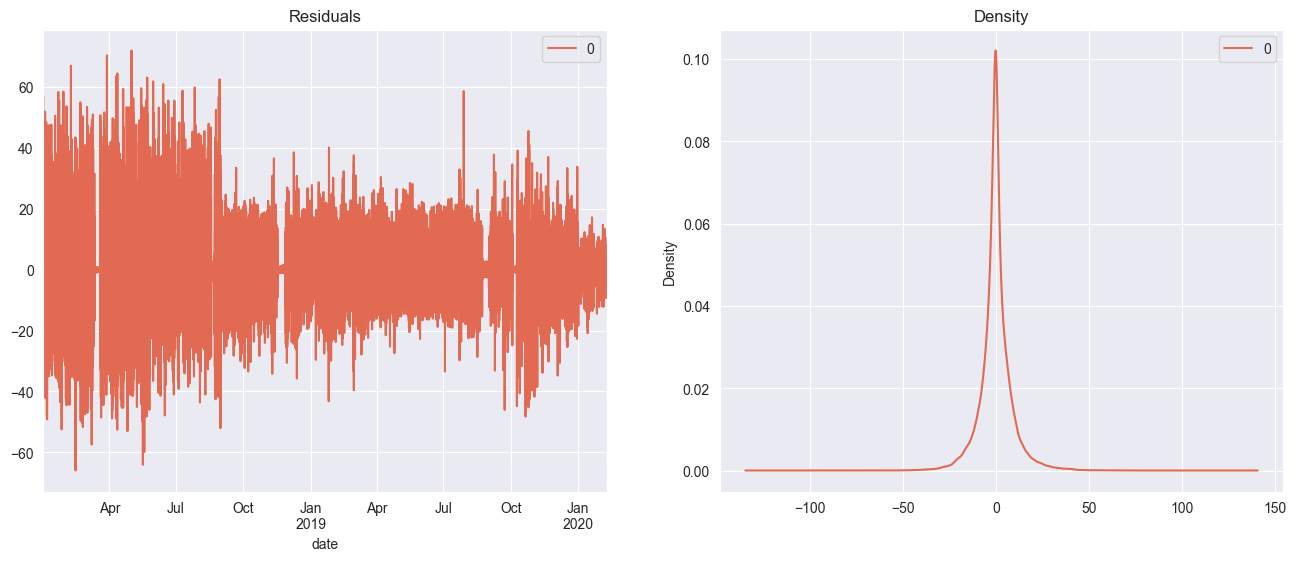

TRAIN SET METRICS
mae: 5.6648837878116085
mape: 6.603741097849683
rmse: 8.753633244411905
TEST SET METRICS
mae: 10.250645987154861
mape: 1.0164663783762093
rmse: 14.174031255664719


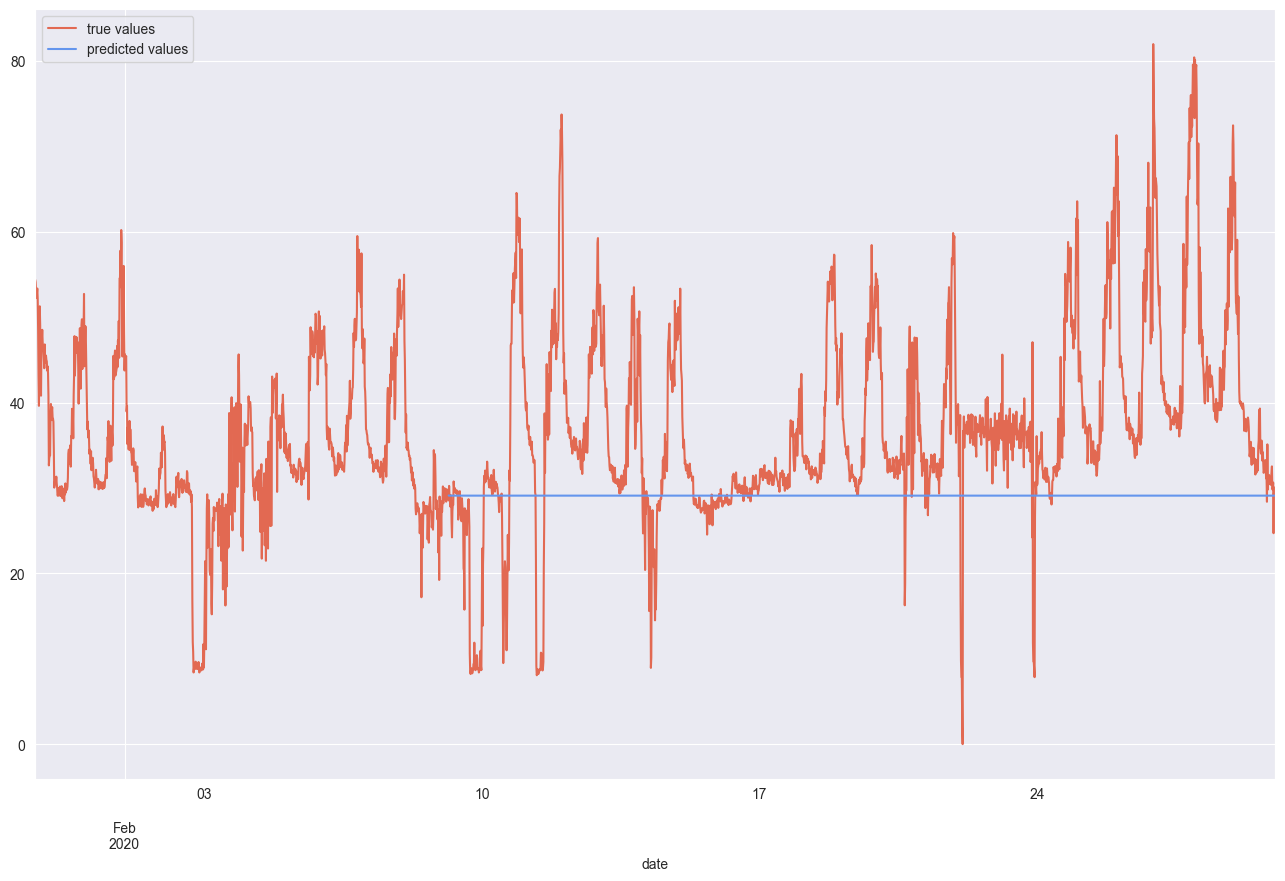

In [57]:
model_arima_tuned = ARIMA(df_train, order =(2,1,2))
model_arima_tuned_fit = model_arima_tuned.fit()
print(model_arima_tuned_fit.summary())


# Plot residual errors
residuals = pd.DataFrame(model_arima_tuned_fit.resid)
fig, ax= plt.subplots(nrows=1,ncols=2, figsize=(16,6) )
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

plot_zoom(model_arima_tuned_fit, energy_use, df_test, len(df_train), var)
metrics(model_arima_tuned_fit, df_test, df_train)




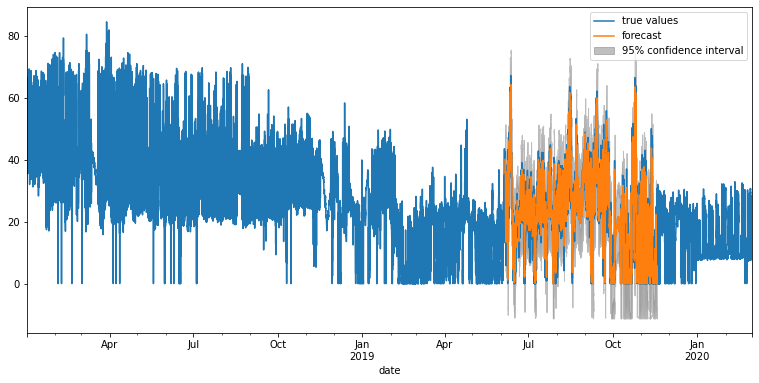

In [41]:
# Actual vs Fitte
fig, ax = plt.subplots(figsize=(13,6))

ax = energy_use[var].plot(label ='true values', ax=ax)

fig = plot_predict(model_arima_tuned_fit, start = start, end = end, ax = ax)
#ax.set_xlim(['2019-01', '2019-02'])
plt.show()

### SARIMAX
We have multiple seasonal components, so probably SARIMAX will not be an adequate option

#### Manual parameter fitting

In [52]:
sarimax_mod = sm.tsa.statespace.SARIMAX(df_train,order=(2,1,2),
                                                seasonal_order=(2,1,2,4),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

sarimax_fit = sarimax_mod.fit(maxiter=50) 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72960D+00    |proj g|=  7.75613D-02

At iterate    5    f=  3.69285D+00    |proj g|=  8.06230D-02

At iterate   10    f=  3.66601D+00    |proj g|=  8.79780D-02

At iterate   15    f=  3.61910D+00    |proj g|=  2.39443D-01

At iterate   20    f=  3.60390D+00    |proj g|=  2.07209D-01

At iterate   25    f=  3.58870D+00    |proj g|=  1.79490D-01

At iterate   30    f=  3.58756D+00    |proj g|=  4.02576D-02

At iterate   35    f=  3.58755D+00    |proj g|=  1.24809D-03

At iterate   40    f=  3.58755D+00    |proj g|=  1.51511D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

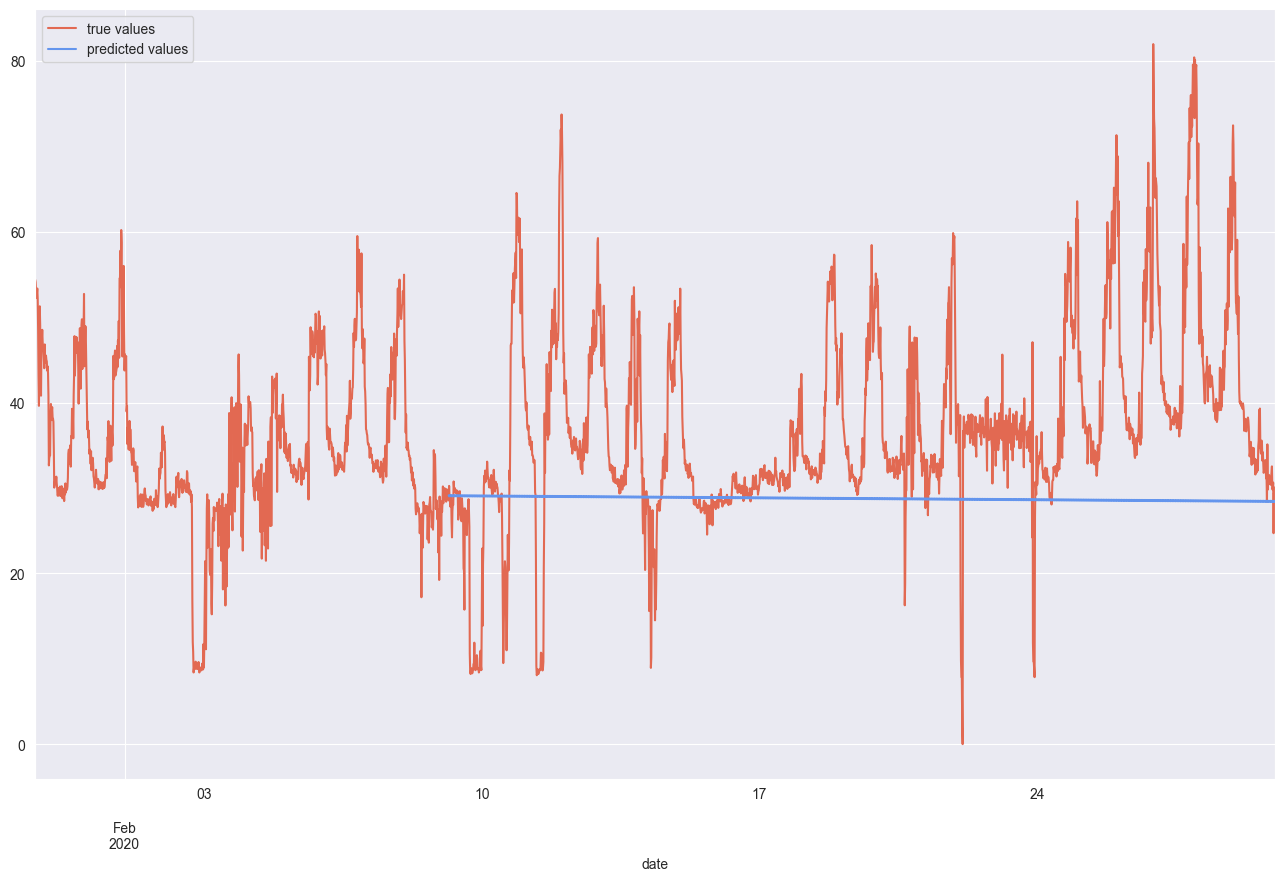

In [55]:
plot_zoom(sarimax_fit, energy_use, df_test,len(df_train),var)

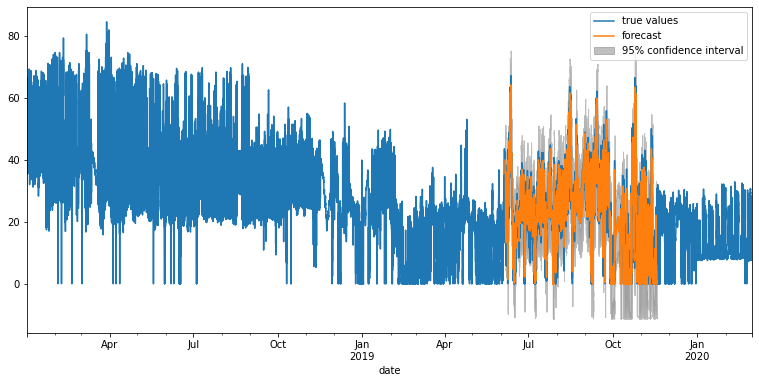

In [44]:

# Actual vs Fitte
fig, ax = plt.subplots(figsize=(13,6))

ax = energy_use[var].plot(label ='true values', ax=ax)

fig = plot_predict(sarimax_fit, start = start, end = end, ax = ax)
#ax.set_xlim(['2019-01', '2019-02'])
plt.legend()
plt.show()

Next, we will compare the MSE of both models:

In [45]:
metrics(sarimax_fit, df_test, df_train)

TRAIN SET METRICS
mae: 3.420660893777796
mape: 9.897882194247527
rmse: 5.734174360284326
TEST SET METRICS
mae: 5.184606048274385
mape: 1.031908494092399
rmse: 8.509291373254456


#### Auto SARIMA
Automatic parameter tuning:

In [14]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from pmdarima.arima import auto_arima

In [31]:


sf = AutoARIMA(season_length = 4)

sf.fit(df_train.values)


AutoARIMA

In [32]:
forecasts = sf.predict(len(df_test))['mean']


In [33]:
# We check the order of the model (so we can make predictions and retrain)
sf.model_['arma']

(3, 1, 0, 2, 4, 1, 0)

In [34]:
results = pd.DataFrame(df_test)
results['forecast']=forecasts

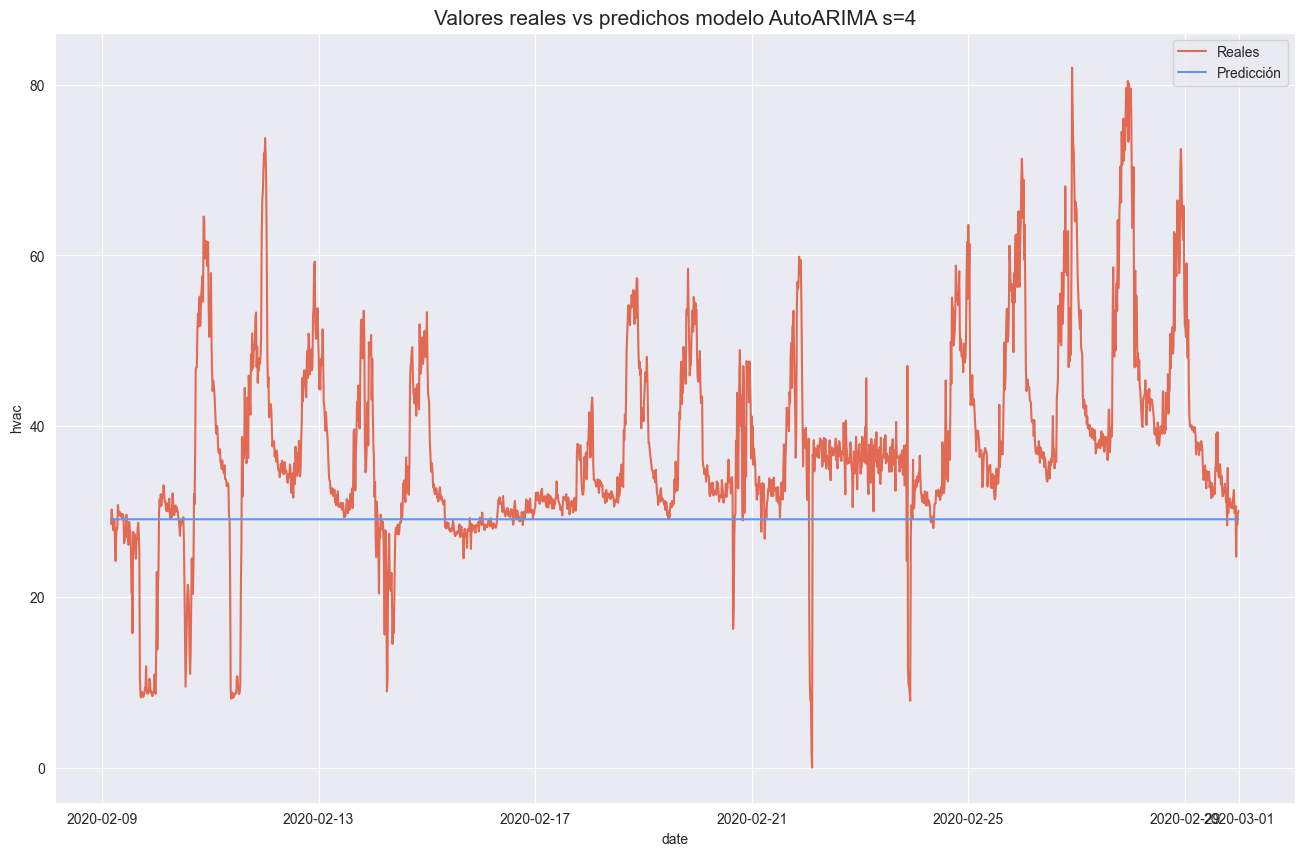

In [35]:
# Plot the forecasts and actual valuesb
plt.figure(figsize=(16, 10))
sns.lineplot(x=results.index, y=results[var], label='Reales')
sns.lineplot(x=results.index, y=results['forecast'], label='Predicción', color='cornflowerblue')

plt.title('Valores reales vs predichos modelo AutoARIMA s=4', fontsize=15)
plt.legend()
plt.show()

#### Auto SARIMA with exogenous variables

We already know that we have multiple seasonal components. However, SARIMAX can't operate with more than one seasonal component. As a solution, we can add Fourier terms (https://tanzu.vmware.com/content/blog/forecasting-time-series-data-with-multiple-seasonal-periods).

In [41]:
from pmdarima.preprocessing import FourierFeaturizer
exog = pd.DataFrame({'date': energy_use.index})


In [42]:
four_terms = FourierFeaturizer(96, 1)
y_prime, exog = four_terms.fit_transform(energy_use[var])
exog['date'] = y_prime.index # is exactly the same as manual calculation in the above cells
exog = exog.set_index(exog['date'])
exog.index.freq = '15T'
exog = exog.drop(columns=['date'])

In [43]:
exog.shape

(75836, 2)

In [44]:
#
#four_terms = FourierFeaturizer(96*7)
#y_prime, exog2 =four_terms.fit_transform(energy_use[var])
#exog2['date'] = y_prime.index # is exactly the same as manual calculation in the above cells
#exog2 = exog2.set_index(exog['date'])
#exog2.index.freq = '15T'
#exog = exog.join(exog2, lsuffix='_w')
#exog = exog.drop(columns=['date_w', 'date'])

In [45]:
exog_to_train = exog.iloc[:-2000,:]
exog_to_test = exog.iloc[-2000:, :]


In [46]:
assert exog_to_train.shape[0] == df_train.shape[0]

In [21]:
#Pendiente: comprobar parámetros de variable exógena - tarda mucho

sf = auto_arima(df_train.values, exog_to_train.values,m = 4)


In [29]:
params = sf.get_params()
print(params)

{'maxiter': 50, 'method': 'lbfgs', 'order': (3, 1, 1), 'out_of_sample_size': 0, 'scoring': 'mse', 'scoring_args': {}, 'seasonal_order': (2, 0, 1, 4), 'start_params': None, 'suppress_warnings': True, 'trend': None, 'with_intercept': False}


In [22]:
forecasts_2=sf.predict(len(df_test), exog_to_test.values)

In [23]:
results = pd.DataFrame(df_test)

In [25]:
results['forecast_exog']=forecasts_2

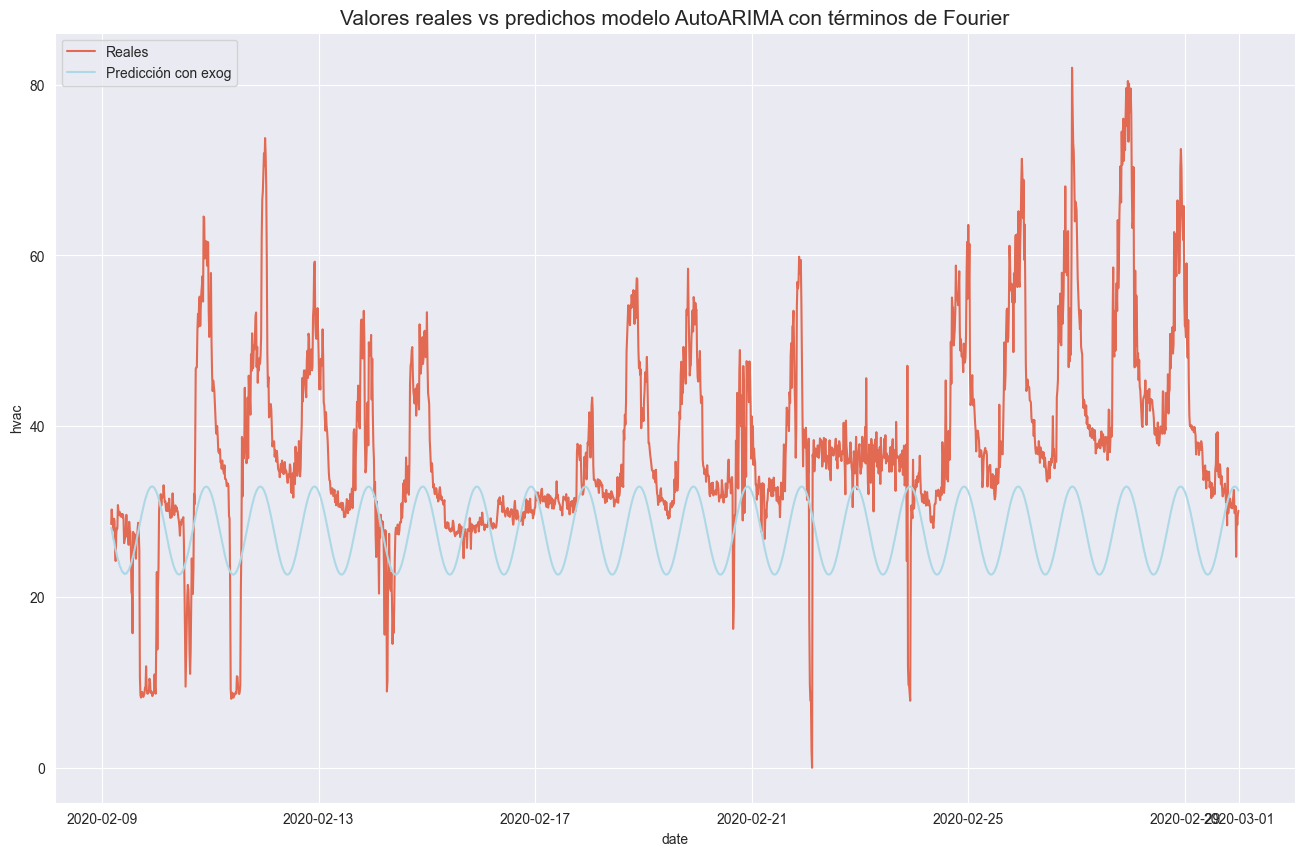

In [26]:

# Plot the forecasts and actual valuesb
plt.figure(figsize=(16, 10))
sns.lineplot(x=results.index, y=results[var], label='Reales')
sns.lineplot(x=results.index, y=results['forecast_exog'], label='Predicción con exog', color='lightblue')

plt.title('Valores reales vs predichos modelo AutoARIMA con términos de Fourier', fontsize=15)
plt.legend()
plt.show()

### SARIMA with exog variables and retraining model

In [53]:
import IPython
import IPython.display

In [47]:
df_train.shape[0] == exog_to_train.shape[0]

True

Iteration:  41
TRAIN SET METRICS
mae: 1.7755222724115762
mape: 0.061995195310062354
rmse: 2.1271247034223513


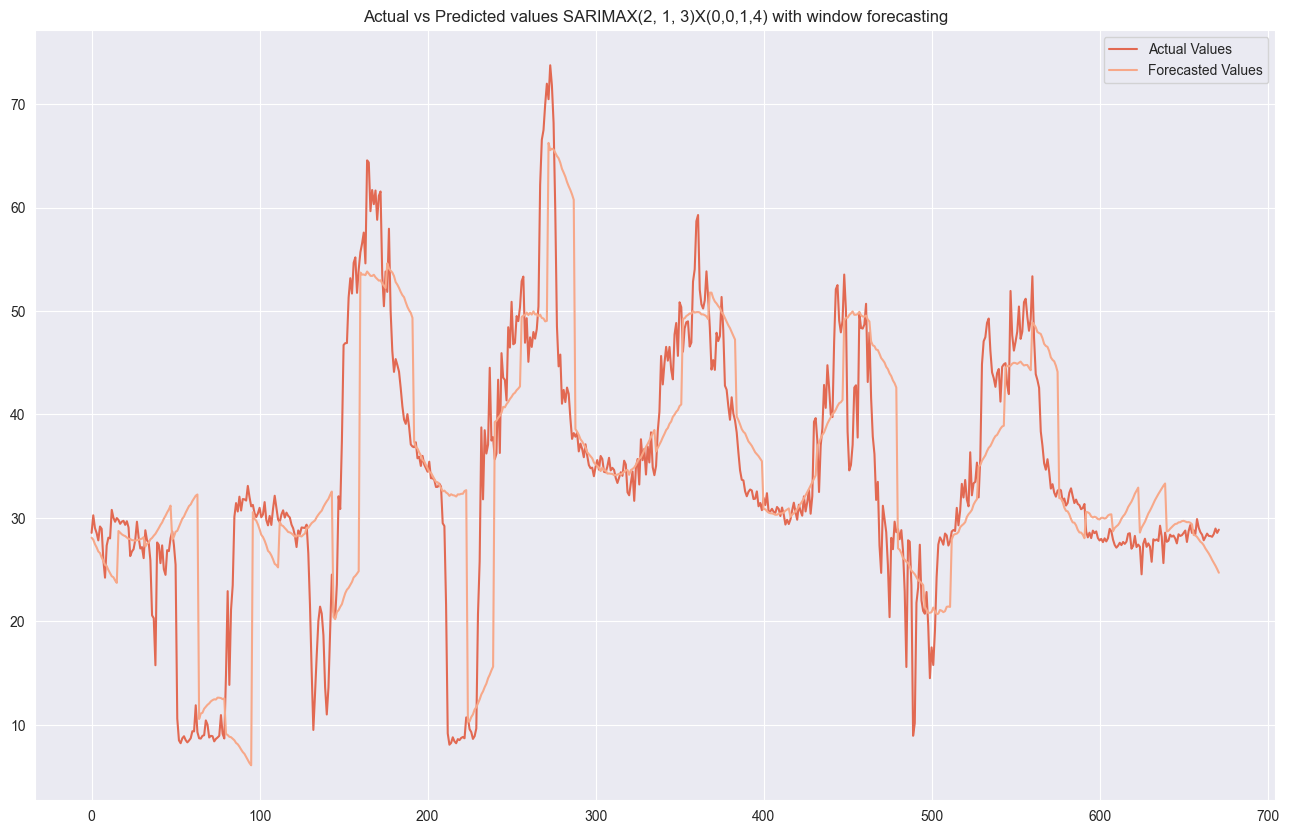

In [59]:
# We will make 4 forecasts and then retrain the model, and repeat this process 24 times (to forecast an entire week)

# Set the number of forecasts to make
n_forecasts = 4*4

# Set the number of iterations to perform (6 iterations => 1 day * 7 => 1 week)
n_iter = 6*7

# Initialize lists to store the forecasts and actual values
forecasts = []
actuals = []

train = df_train.copy()
exog = exog_to_train.copy()

# Loop through the iterations
for i in range(n_iter):
    
    

    index = i*n_forecasts
    # Fit the SARIMAX model on the training data
    sarimax_mod = sm.tsa.statespace.SARIMAX(train,exog.values ,**params)
    sarimax_fit = sarimax_mod.fit(maxiter=50, disp=0) 
    
    
    # Make a forecast for the next n_forecasts periods
    forecast = sarimax_fit.forecast(exog=exog_to_test.iloc[index:index+n_forecasts].values,steps=n_forecasts)
    IPython.display.clear_output()
    print("Iteration: ", i)

    metrics2(forecast, df_test.iloc[index:index+n_forecasts])
    # Add the forecast to the list of forecasts
    forecasts.extend(forecast)
    
    # Add the actual values for the next n_forecasts periods to the list of actuals
    actuals.extend(df_test.iloc[index:index+n_forecasts])
    
    
    plt.figure(figsize=(16, 10))
    plt.plot(actuals, label='Actual Values')
    plt.plot(forecasts, label='Forecasted Values')
    plt.title('Actual vs Predicted values SARIMAX(2, 1, 3)X(0,0,1,4) with window forecasting')
    plt.legend()
    plt.show()
   
    
    
    # Update the training data with the actual values
    train = pd.concat([train, df_test.iloc[index:index+n_forecasts]])
    exog = pd.concat([exog,exog_to_test.iloc[index:index+n_forecasts]])
    
    
    


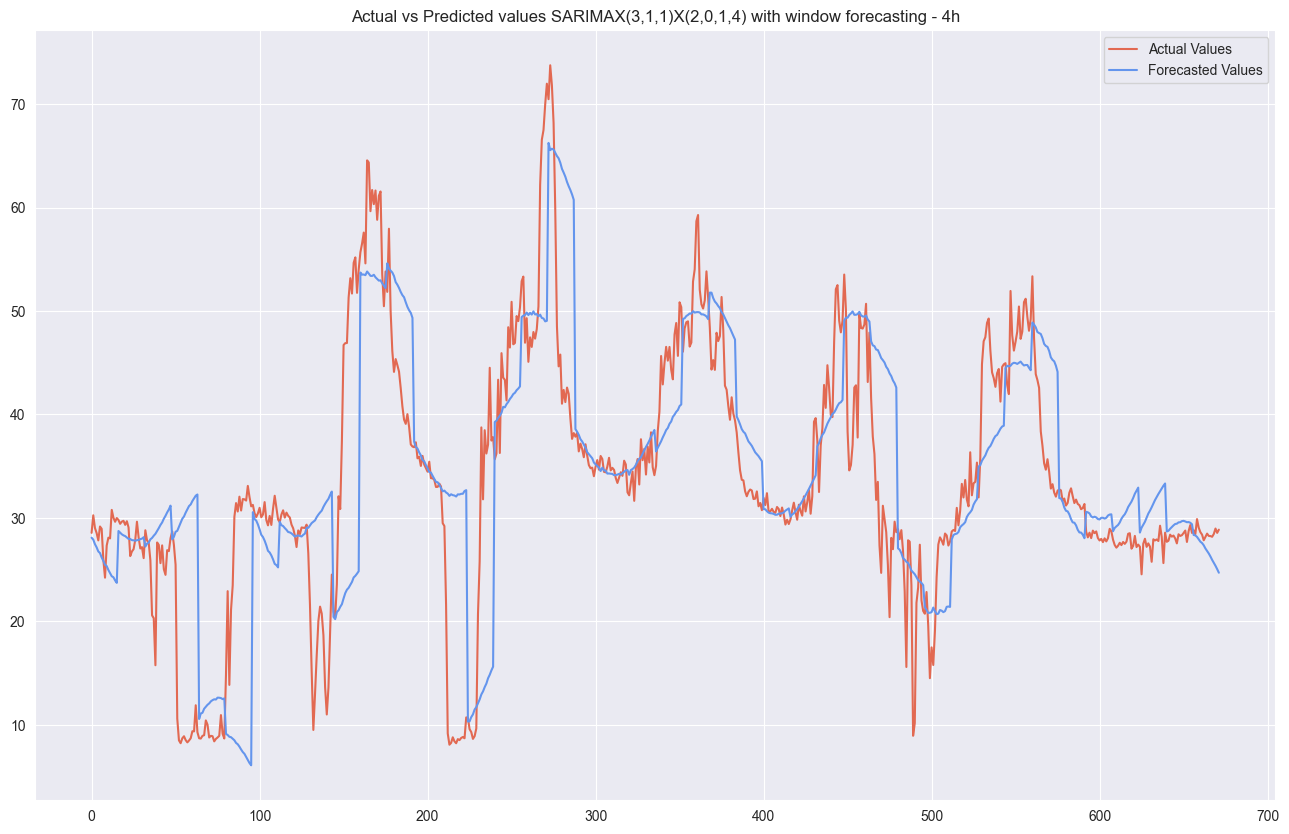

In [60]:

# Plot the forecasts and actual values
plt.figure(figsize=(16, 10))
plt.plot(actuals, label='Actual Values')
plt.plot(forecasts, label='Forecasted Values', color='cornflowerblue')
plt.title('Actual vs Predicted values SARIMAX(3,1,1)X(2,0,1,4) with window forecasting - 4h')
plt.legend()
plt.show()

In [64]:
results_window = pd.DataFrame(actuals)
results_window['prediction_4']=forecasts

In [65]:
metrics2(forecasts, actuals)

TRAIN SET METRICS
mae: 6.038937512123772
mape: 0.2616695127463892
rmse: 9.302716107772682


Iteration:  20
TRAIN SET METRICS
mae: 1.1144630035957512
mape: 0.03923790142673715
rmse: 1.3569431477541845


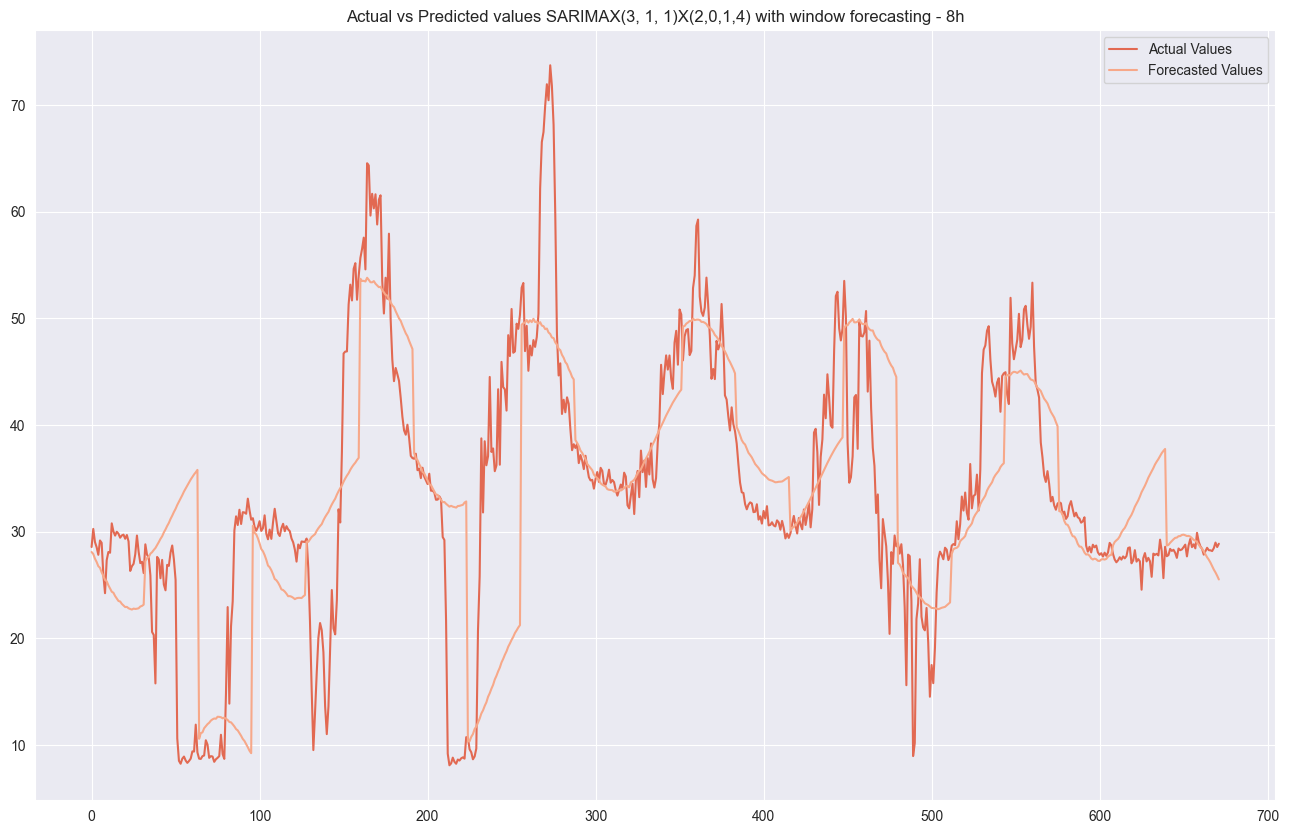

In [62]:
# We will make 4 forecasts and then retrain the model, and repeat this process 24 times (to forecast an entire week)

# Set the number of forecasts to make
n_forecasts = 4*4*2

# Set the number of iterations to perform (6 iterations => 1 day * 7 => 1 week)
n_iter = 3*7

# Initialize lists to store the forecasts and actual values
forecasts_2 = []
actuals_2 = []

train = df_train.copy()
exog = exog_to_train.copy()

# Loop through the iterations
for i in range(n_iter):
    
    

    index = i*n_forecasts
    # Fit the SARIMAX model on the training data
    sarimax_mod = sm.tsa.statespace.SARIMAX(train,exog.values ,**params)
    sarimax_fit = sarimax_mod.fit(maxiter=50, disp=0) 
    
    
    # Make a forecast for the next n_forecasts periods
    forecast = sarimax_fit.forecast(exog=exog_to_test.iloc[index:index+n_forecasts].values,steps=n_forecasts)
    IPython.display.clear_output()
    print("Iteration: ", i)

    metrics2(forecast, df_test.iloc[index:index+n_forecasts])
    # Add the forecast to the list of forecasts
    forecasts_2.extend(forecast)
    
    # Add the actual values for the next n_forecasts periods to the list of actuals
    actuals_2.extend(df_test.iloc[index:index+n_forecasts])
    
    
    plt.figure(figsize=(16, 10))
    plt.plot(actuals_2, label='Actual Values')
    plt.plot(forecasts_2, label='Forecasted Values')
    plt.title('Actual vs Predicted values SARIMAX(3, 1, 1)X(2,0,1,4) with window forecasting - 8h')
    plt.legend()
    plt.show()
   
    
    
    # Update the training data with the actual values
    train = pd.concat([train, df_test.iloc[index:index+n_forecasts]])
    exog = pd.concat([exog,exog_to_test.iloc[index:index+n_forecasts]])
    
    
    


In [66]:
results_window['forecast_8']=forecasts_2

In [71]:
results_window.columns=['hvac','forecast_4', 'forecast_8' ]

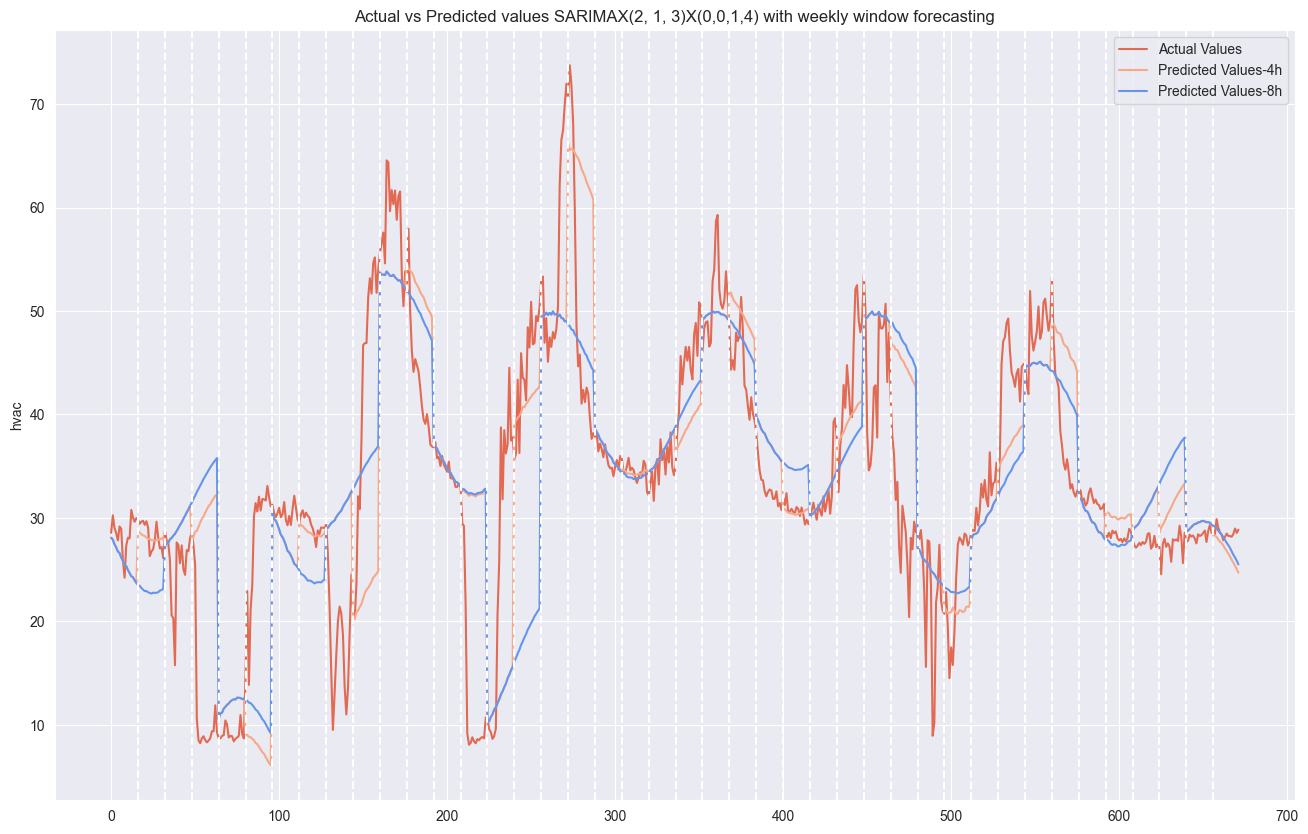

In [75]:

# Plot the forecasts and actual values
plt.figure(figsize=(16, 10))
sns.lineplot(x=results_window.index, y=results_window['hvac'], label='Actual Values')
sns.lineplot(x=results_window.index, y=results_window['forecast_4'], label='Predicted Values-4h')
sns.lineplot(x=results_window.index, y=results_window['forecast_8'], label='Predicted Values-8h', color='cornflowerblue')

for i in range(16, len(results_window.hvac), 16):
    plt.axvline(x=i, color='white', linestyle='--')

plt.title('Actual vs Predicted values SARIMAX(2, 1, 3)X(0,0,1,4) with weekly window forecasting')
plt.legend()
plt.show()

In [76]:
metrics2(forecasts_2, actuals_2)

TRAIN SET METRICS
mae: 6.4806644388350625
mape: 0.2813169253433794
rmse: 9.684349101567795


#### Window forecasting with predicted values

Iteration:  5
TRAIN SET METRICS
mae: 19.47936622759955
mape: 0.3662759062165578
rmse: 20.89941824639519


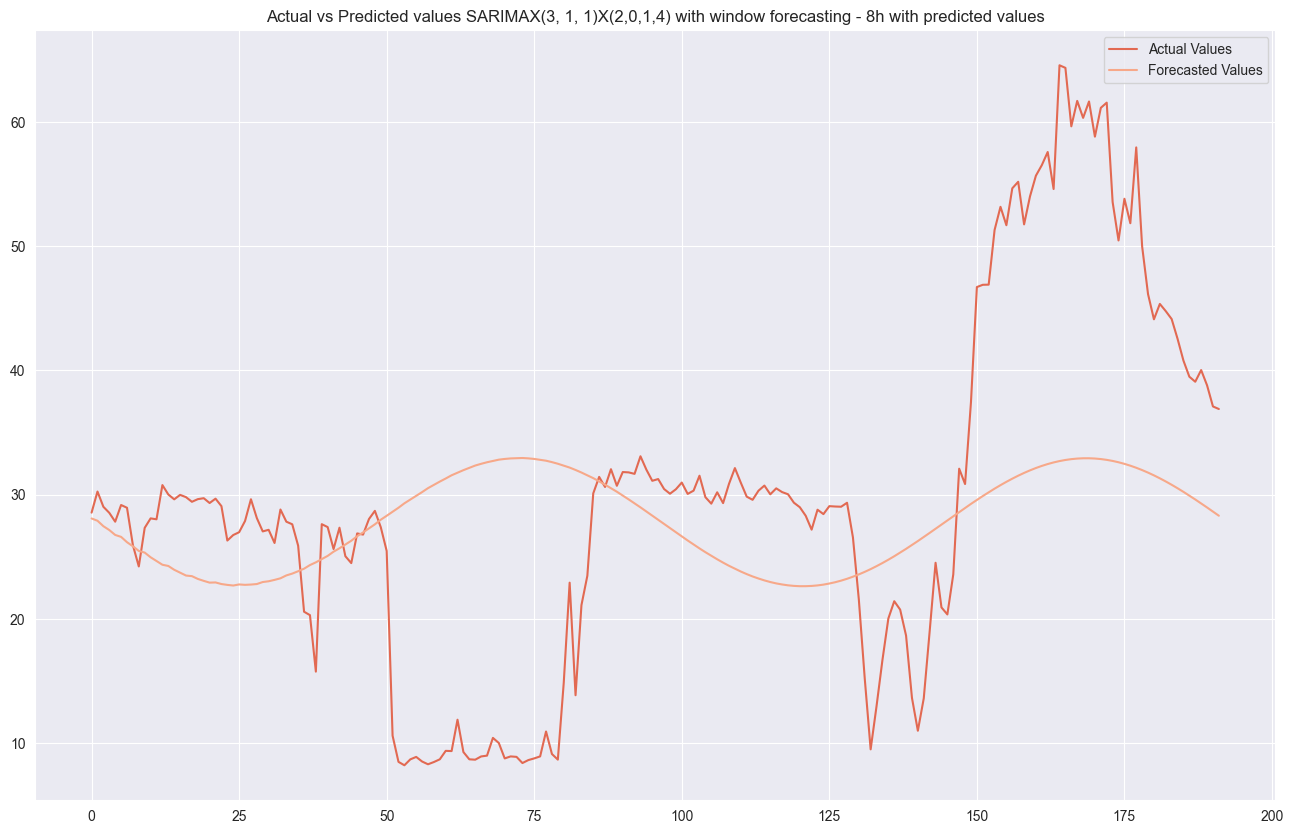

In [ ]:
# We will make 32 forecasts (8h) and then retrain the model with PREDICTED VALUES, and repeat this process 21 times (to forecast an entire week)

# Set the number of forecasts to make
n_forecasts = 32

# Set the number of iterations to perform
n_iter = 21

# Initialize lists to store the forecasts and actual values
forecasts_3 = []
actuals_3 = []

train = df_train.copy()
exog = exog_to_train.copy()


# Loop through the iterations
for i in range(n_iter):
    
    index = i*n_forecasts
    # Fit the SARIMAX model on the training data
    sarimax_mod = sm.tsa.statespace.SARIMAX(train,exog.values ,**params)
    sarimax_fit = sarimax_mod.fit(maxiter=50, disp=0) 
    
    
    # Make a forecast for the next n_forecasts periods
    forecast = sarimax_fit.forecast(exog=exog_to_test.iloc[index:index+n_forecasts].values,steps=n_forecasts)
    IPython.display.clear_output()
    print("Iteration: ", i)

    metrics2(forecast, df_test.iloc[index:index+n_forecasts])
    # Add the forecast to the list of forecasts
    forecasts_3.extend(forecast)
    
    # Add the actual values for the next n_forecasts periods to the list of actuals
    actuals_3.extend(df_test.iloc[index:index+n_forecasts])
    
    
    plt.figure(figsize=(16, 10))
    plt.plot(actuals_3, label='Actual Values')
    plt.plot(forecasts_3, label='Forecasted Values')
    plt.title('Actual vs Predicted values SARIMAX(3, 1, 1)X(2,0,1,4) with window forecasting - 8h with predicted values')
    plt.legend()
    plt.show()
   
    
    
    # Update the training data with the actual values
    train = pd.concat([train, pd.Series(forecasts_3[index:index+n_forecasts], index=df_test.iloc[index:index+n_forecasts].index)])
    exog = pd.concat([exog,exog_to_test.iloc[index:index+n_forecasts]])


In [94]:
results_window['forecast_pred']=forecasts_3

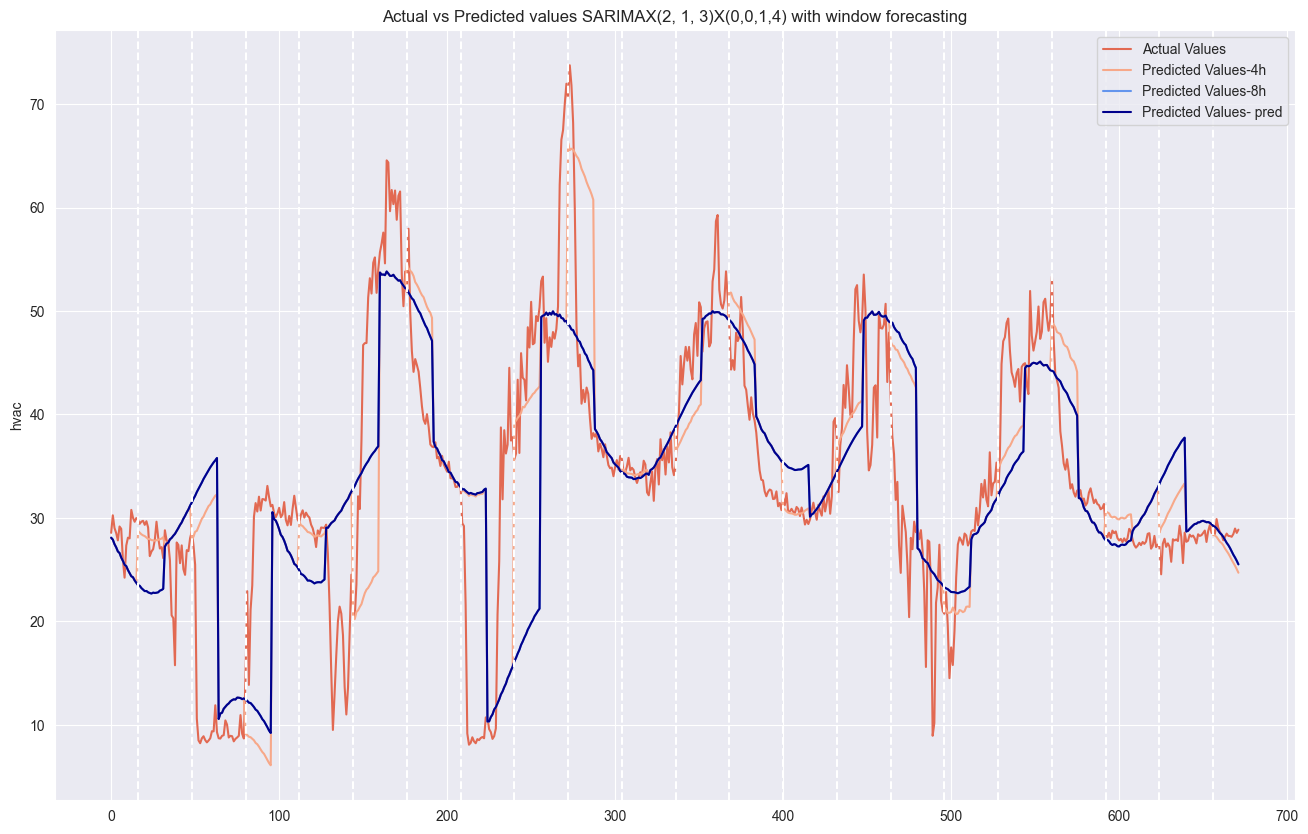

In [96]:

# Plot the forecasts and actual values
plt.figure(figsize=(16, 10))
sns.lineplot(x=results_window.index, y=results_window['hvac'], label='Actual Values')
sns.lineplot(x=results_window.index, y=results_window['forecast_4'], label='Predicted Values-4h')
sns.lineplot(x=results_window.index, y=results_window['forecast_8'], label='Predicted Values-8h', color='cornflowerblue')
sns.lineplot(x=results_window.index, y=results_window['forecast_pred'], label='Predicted Values- pred', color='darkblue')

for i in range(16, len(results_window.hvac), 32):
    plt.axvline(x=i, color='white', linestyle='--')

plt.title('Actual vs Predicted values SARIMAX(2, 1, 3)X(0,0,1,4) with window forecasting')
plt.legend()
plt.show()

### Prophet
We will try a very simple model and check if we still have overfitting:

In [13]:
from prophet import Prophet
import itertools
from prophet.diagnostics import cross_validation, performance_metrics

In [14]:

df_train_p = df_train.reset_index()
df_train_p.columns=['ds', 'y']
df_test_p = df_test.reset_index()
df_test_p.columns=['ds', 'y']

In [15]:
model = Prophet(changepoint_range=0.9)
model.add_seasonality(name='hourly', period=4, fourier_order=3)
model.fit(df_train_p )

09:42:32 - cmdstanpy - INFO - Chain [1] start processing
09:43:03 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
#Out of sample forecast
future = df_test_p[['ds']]
forecast = model.predict(future)

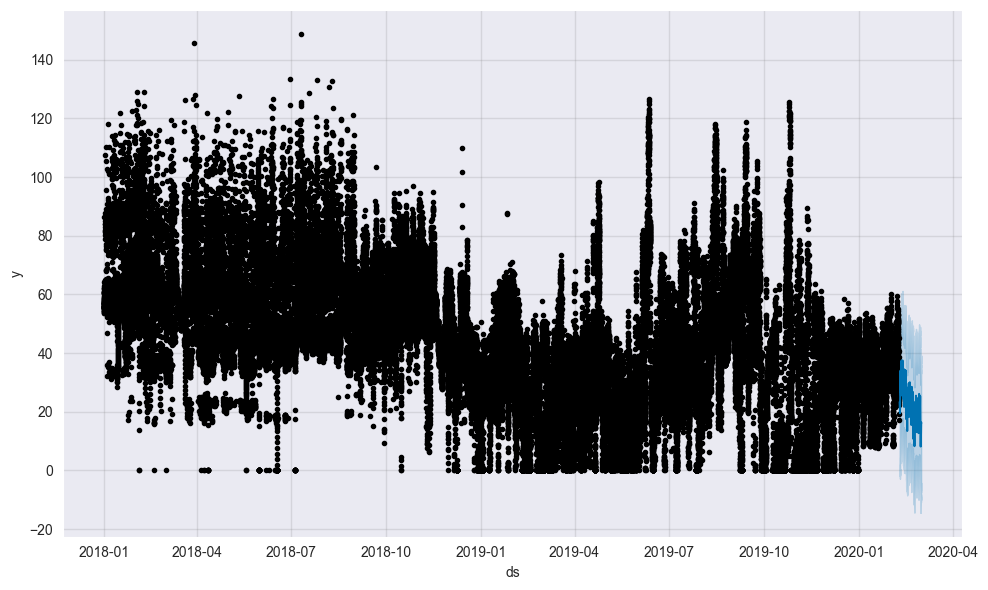

In [17]:
fig1 = model.plot(forecast)


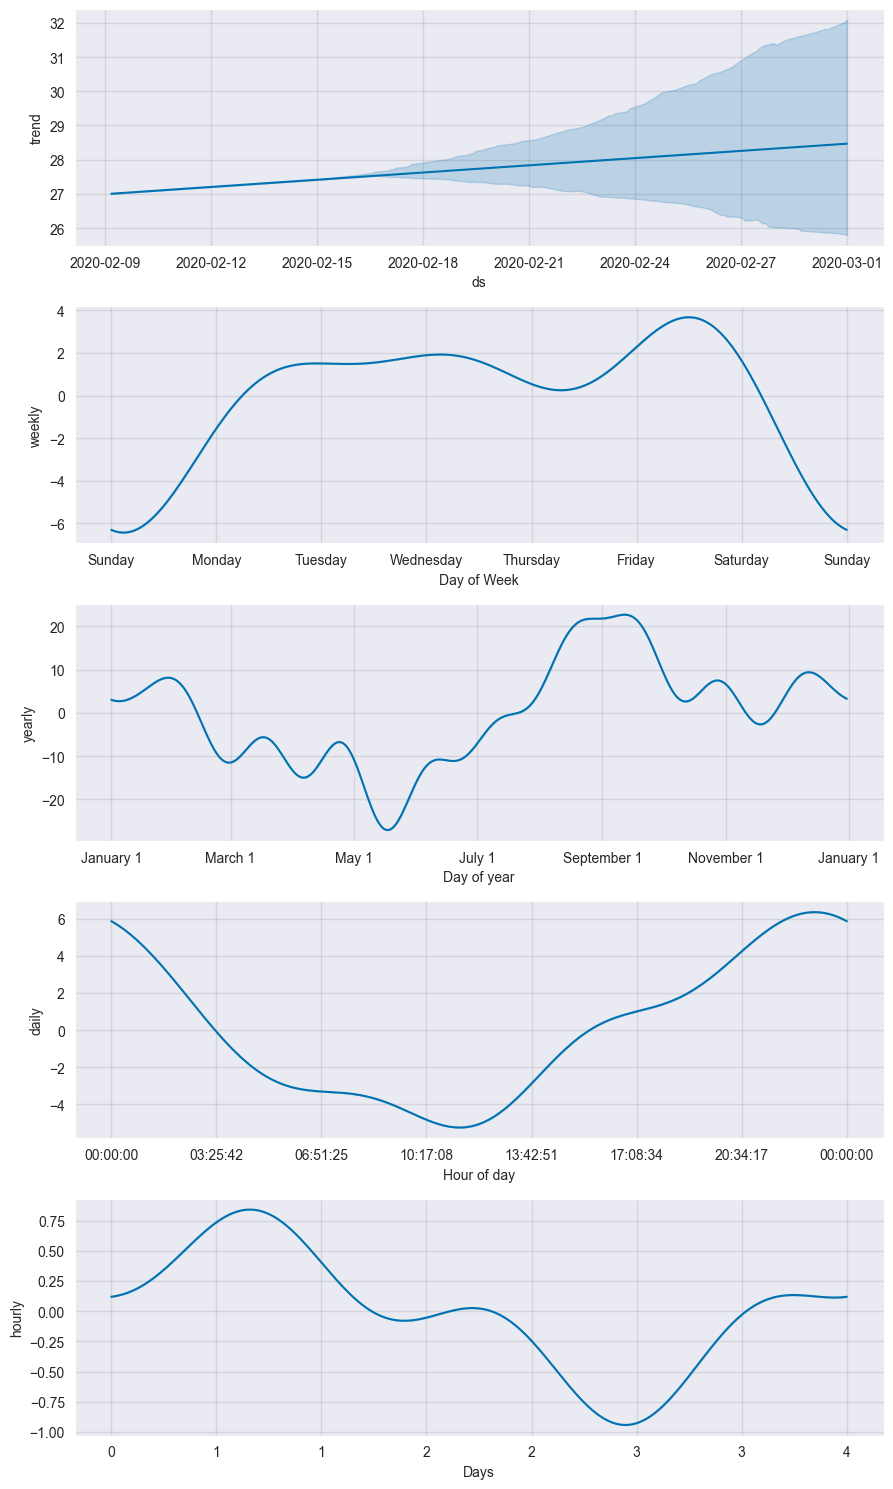

In [18]:
fig2 = model.plot_components(forecast)


In [19]:
from prophet.plot import plot_plotly, plot_components_plotly



Next, we will check the in sample predictions


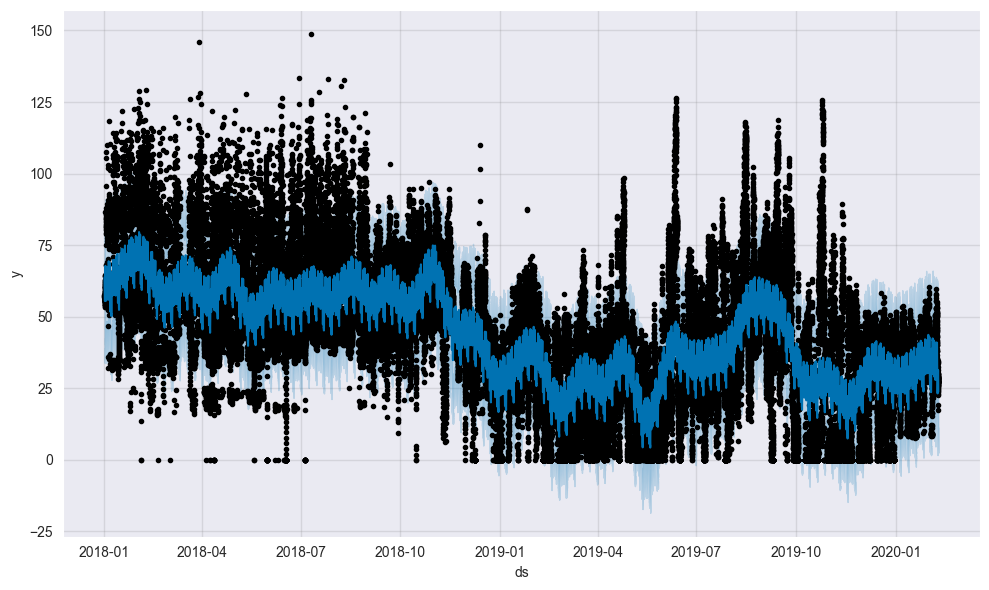

In [20]:
#Out of sample forecast
future = df_train_p[['ds']]
forecast = model.predict(future)
fig1 = model.plot(forecast)


We see that it picks up some of the movement of the time series, but not really, since it doesn't model all the peaks.

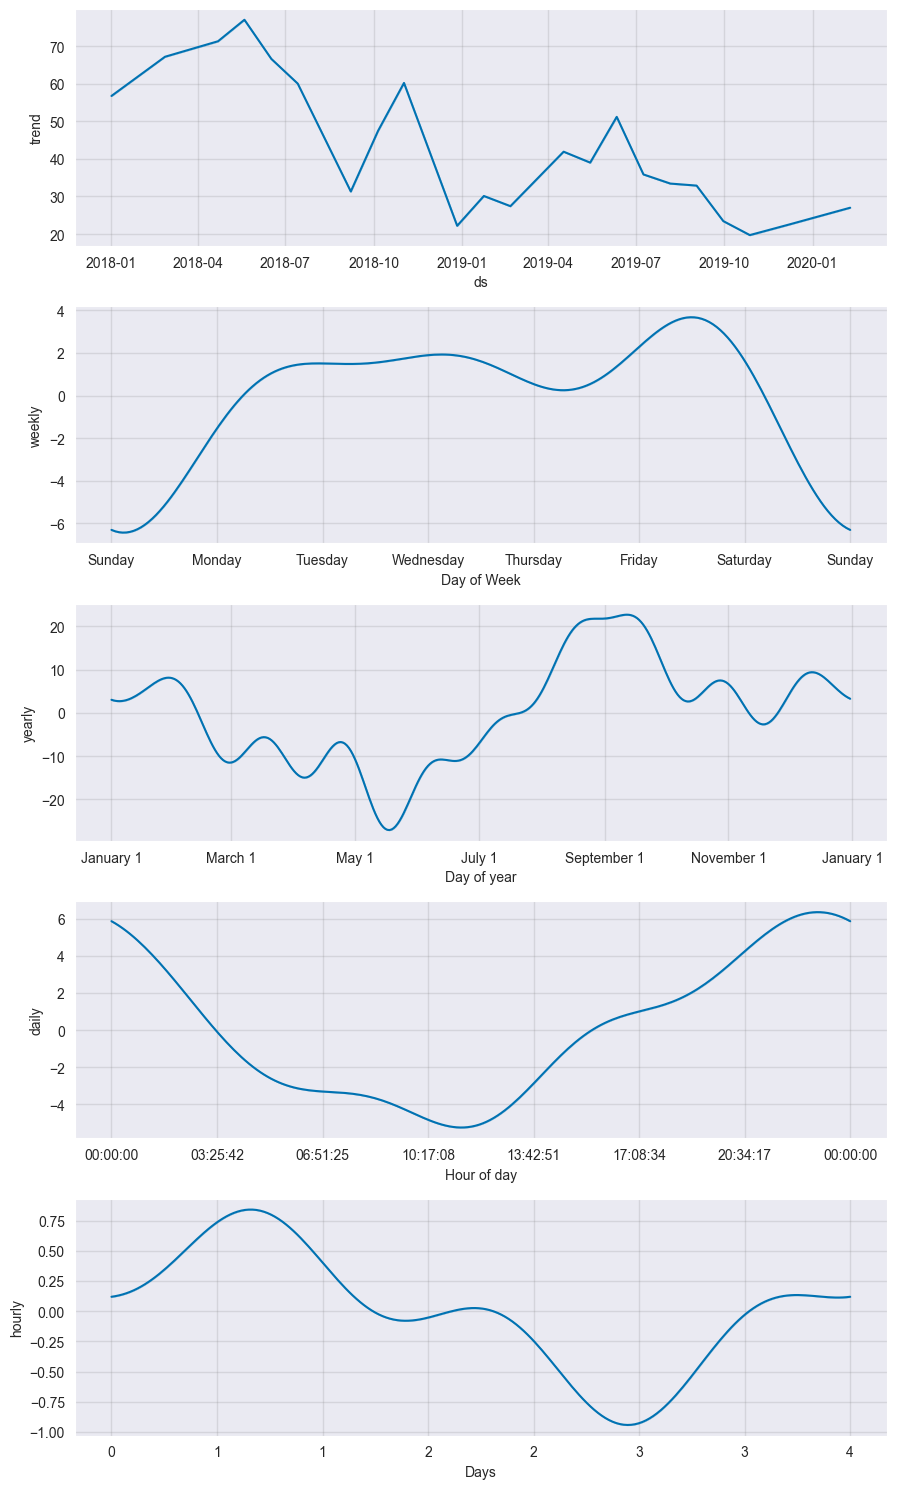

In [21]:
fig2 = model.plot_components(forecast)


Now we will repeat some of the plots we had with previous models, so we can compare them:


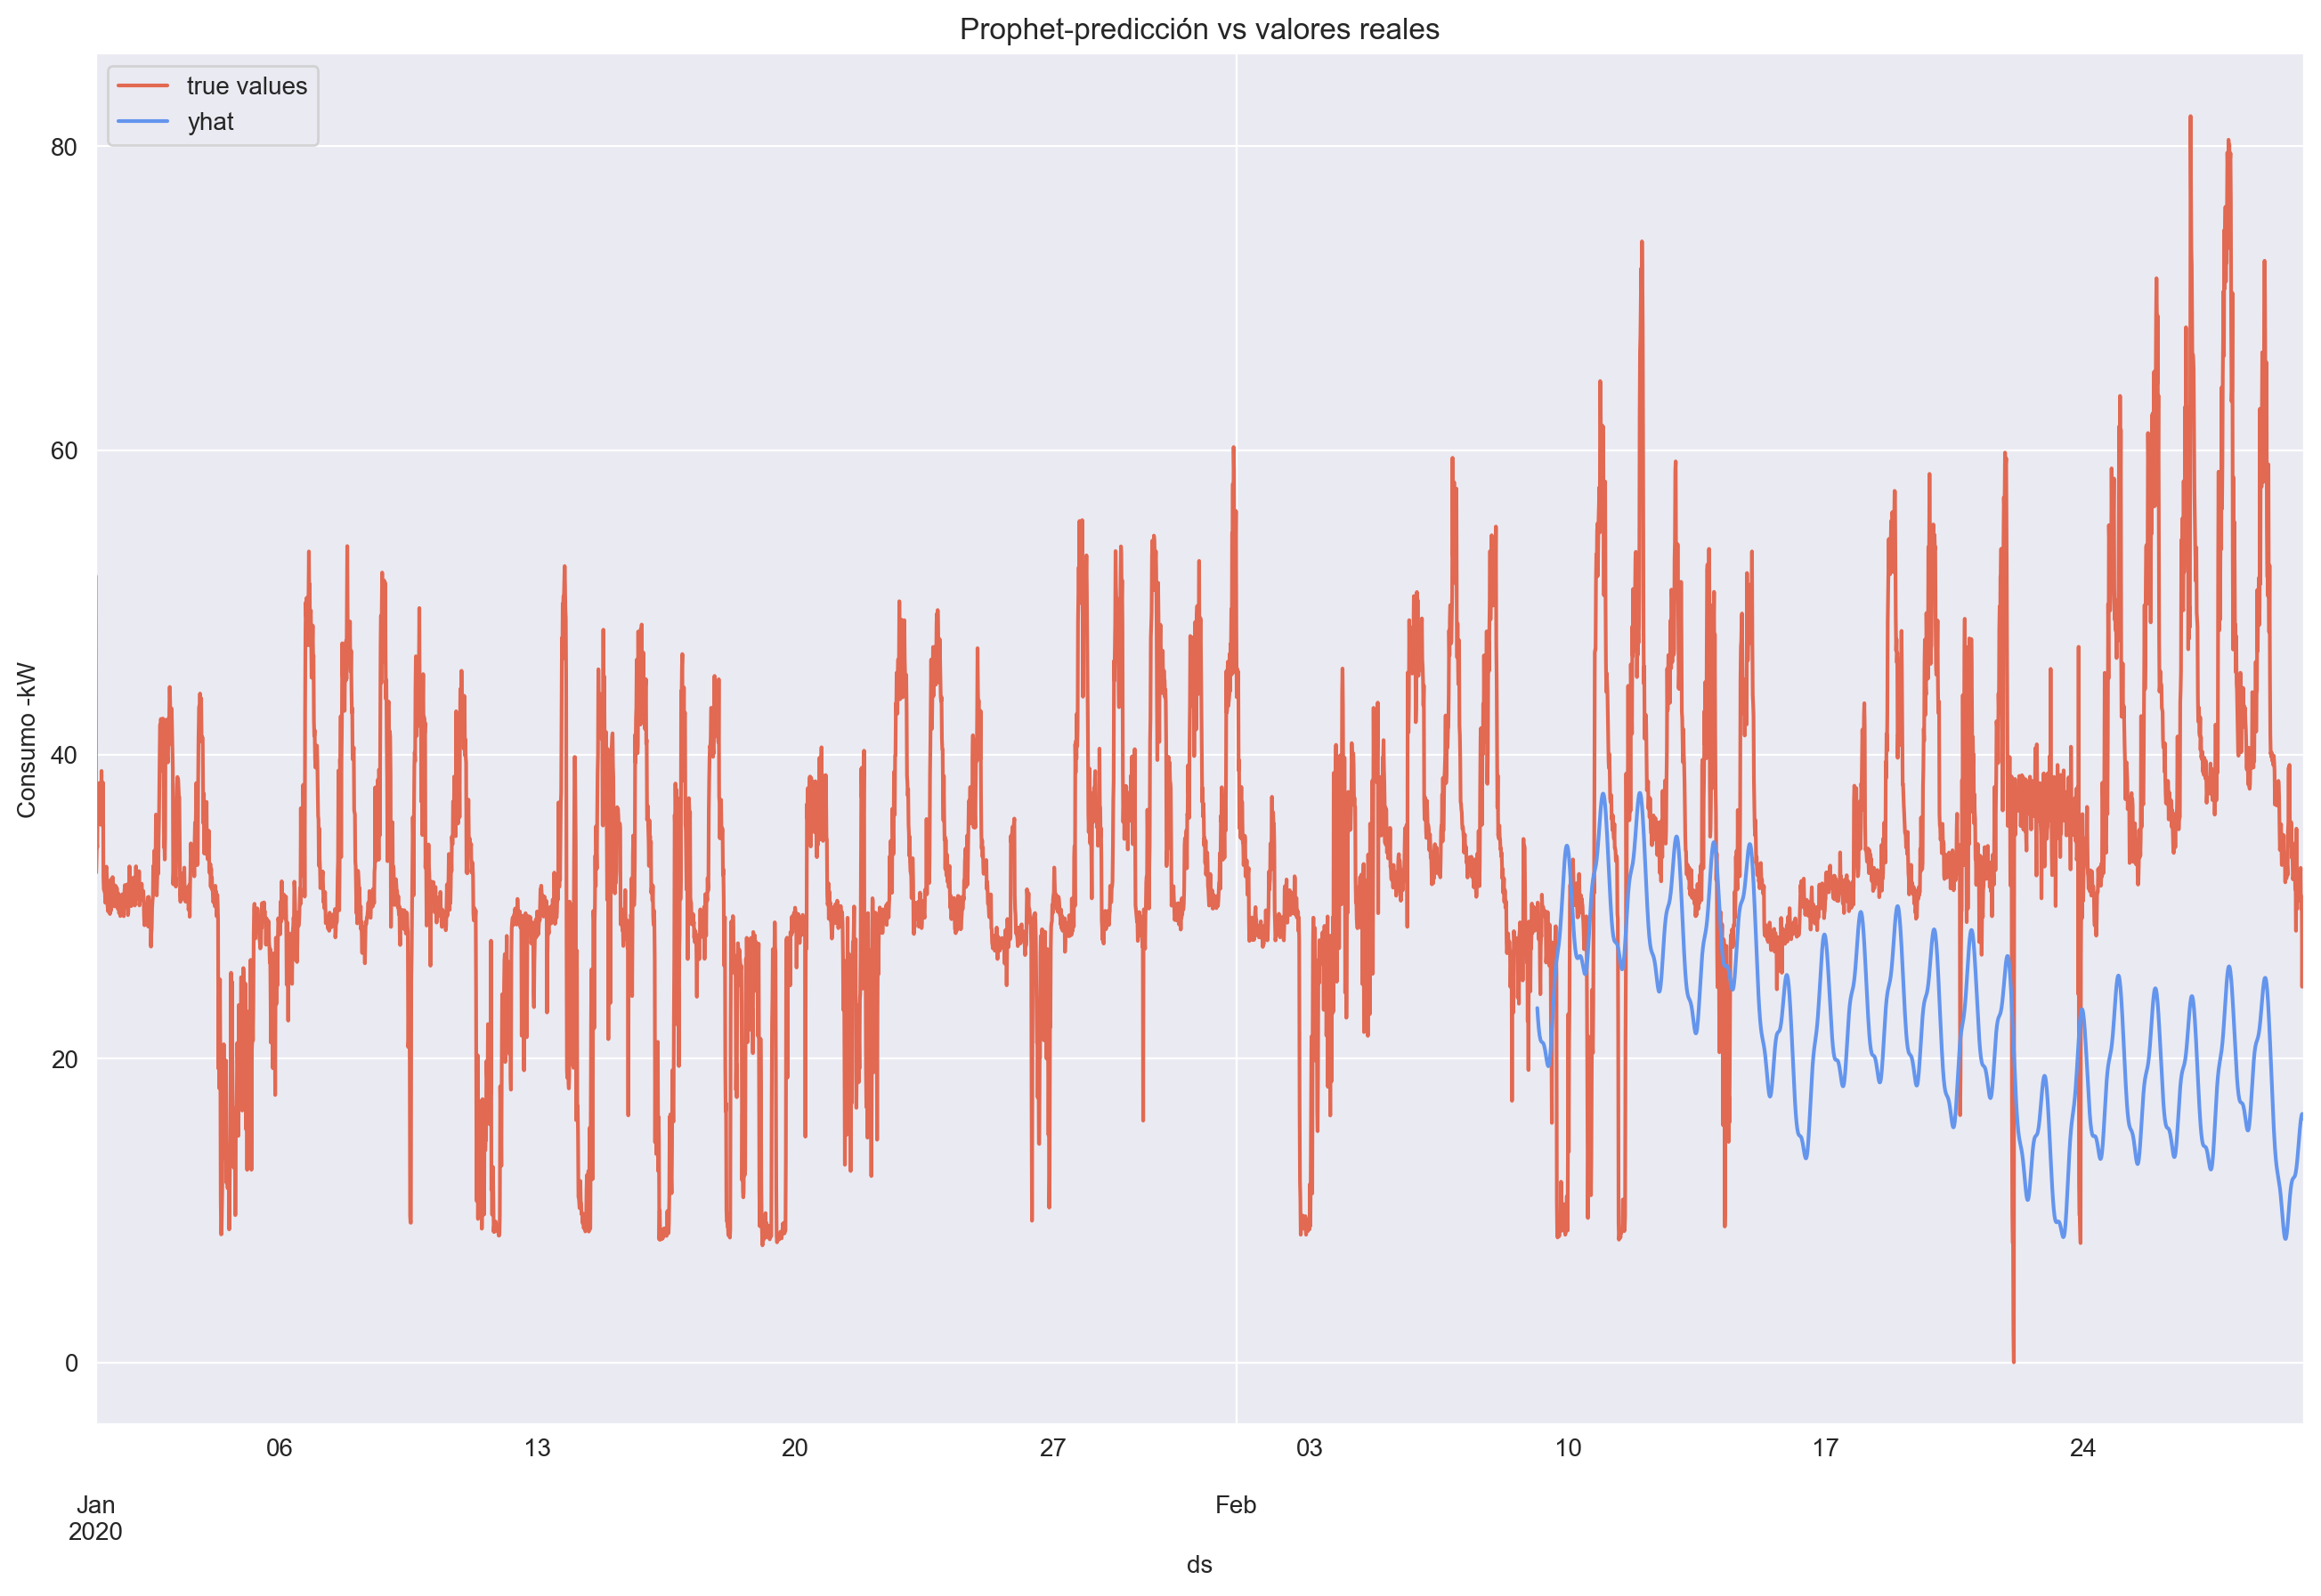

In [25]:
plt.figure(figsize=(16, 10), dpi=200)
df = energy_use
#Out of sample forecast
future = df_test_p[['ds']]
forecast = model.predict(future)[['ds', 'yhat']].set_index('ds')
ax = df[df.index.year == 2020][var].plot(label='true values')
forecast.plot(label='predicted values', ax=ax, color='cornflowerblue')
plt.title('Prophet-predicción vs valores reales')
plt.ylabel('Consumo -kW')
plt.legend()

In [41]:
# We are going to do cross validation

model_prophet_cv = cross_validation(model, initial='380 days', period='30 days', horizon = '30 days', parallel="processes")
# Model performance metrics
model_prophet_cv_metrics = performance_metrics(model_prophet_cv, rolling_window=1)

16:41:42 - cmdstanpy - INFO - Chain [1] start processing
16:41:43 - cmdstanpy - INFO - Chain [1] start processing
16:41:43 - cmdstanpy - INFO - Chain [1] start processing
16:42:00 - cmdstanpy - INFO - Chain [1] start processing
16:42:01 - cmdstanpy - INFO - Chain [1] start processing
16:42:02 - cmdstanpy - INFO - Chain [1] start processing
16:42:03 - cmdstanpy - INFO - Chain [1] start processing
16:42:04 - cmdstanpy - INFO - Chain [1] start processing
16:42:05 - cmdstanpy - INFO - Chain [1] start processing
16:42:05 - cmdstanpy - INFO - Chain [1] start processing
16:42:06 - cmdstanpy - INFO - Chain [1] start processing
16:44:27 - cmdstanpy - INFO - Chain [1] done processing
16:44:29 - cmdstanpy - INFO - Chain [1] done processing
16:44:45 - cmdstanpy - INFO - Chain [1] start processing
16:44:48 - cmdstanpy - INFO - Chain [1] start processing
16:45:31 - cmdstanpy - INFO - Chain [1] done processing
16:45:49 - cmdstanpy - INFO - Chain [1] start processing
16:47:16 - cmdstanpy - INFO - Chai

In [35]:
model_prophet_cv_metrics

NameError: name 'model_prophet_cv_metrics' is not defined

In [39]:
# Set up parameter grid
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.05, 0.08, 0.5],
    'seasonality_prior_scale': [0.01, 1, 5, 10, 12],
    'seasonality_mode': ['additive', 'multiplicative']
}
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# Create a list to store MAPE values for each combination
mapes = [] 
# Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params)
    m.add_seasonality(name='hourly', period=4, fourier_order=3)
    m.fit(df_train_p)  
    # Cross-validation
    df_cv = cross_validation(m, initial='360 days', period='80 days', horizon = '100 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    mapes.append(df_p['mape'].values[0])
    
# Tuning results
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes
# Find the best parameters
best_params = all_params[np.argmin(mapes)]
print(best_params)

15:33:09 - cmdstanpy - INFO - Chain [1] start processing
15:33:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:33:17 - cmdstanpy - INFO - Chain [1] start processing
15:33:17 - cmdstanpy - INFO - Chain [1] start processing
15:33:18 - cmdstanpy - INFO - Chain [1] start processing
15:33:18 - cmdstanpy - INFO - Chain [1] start processing
15:33:21 - cmdstanpy - INFO - Chain [1] done processing
15:33:23 - cmdstanpy - INFO - Chain [1] done processing
15:33:25 - cmdstanpy - INFO - Chain [1] done processing
15:33:27 - cmdstanpy - INFO - Chain [1] done processing
15:33:31 - cmdstanpy - INFO - Chain [1] start processing
15:33:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
15:33:38 - cmdstanpy - INFO - Chain [1] start processing
15:33:39 - cmdstanpy - INFO - Chain [1] start processing


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive'}


In [41]:
auto_model = Prophet(changepoint_prior_scale=0.001, 
                     seasonality_prior_scale=0.01, 
                     seasonality_mode='additive')

auto_model.add_seasonality(name='hourly', period=4, fourier_order=3)

# Fit the model on the training dataset
auto_model.fit(df_train_p)
# Cross validation
auto_model_cv = cross_validation(auto_model, initial='370 days', period='80 days', horizon = '100 days', parallel="processes")
# Model performance metrics
auto_model_p = performance_metrics(auto_model_cv, rolling_window=1)


16:45:33 - cmdstanpy - INFO - Chain [1] start processing
16:45:36 - cmdstanpy - INFO - Chain [1] done processing
16:45:39 - cmdstanpy - INFO - Chain [1] start processing
16:45:40 - cmdstanpy - INFO - Chain [1] start processing
16:45:40 - cmdstanpy - INFO - Chain [1] start processing
16:45:41 - cmdstanpy - INFO - Chain [1] start processing
16:45:43 - cmdstanpy - INFO - Chain [1] done processing
16:45:43 - cmdstanpy - INFO - Chain [1] done processing
16:45:46 - cmdstanpy - INFO - Chain [1] done processing
16:45:48 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
print(auto_model_p)

   horizon         mse       rmse        mae        mape     mdape     smape  \
0 100 days  606.075131  24.618593  19.389061  118.372313  0.470502  0.727322   

   coverage  
0  0.604505  


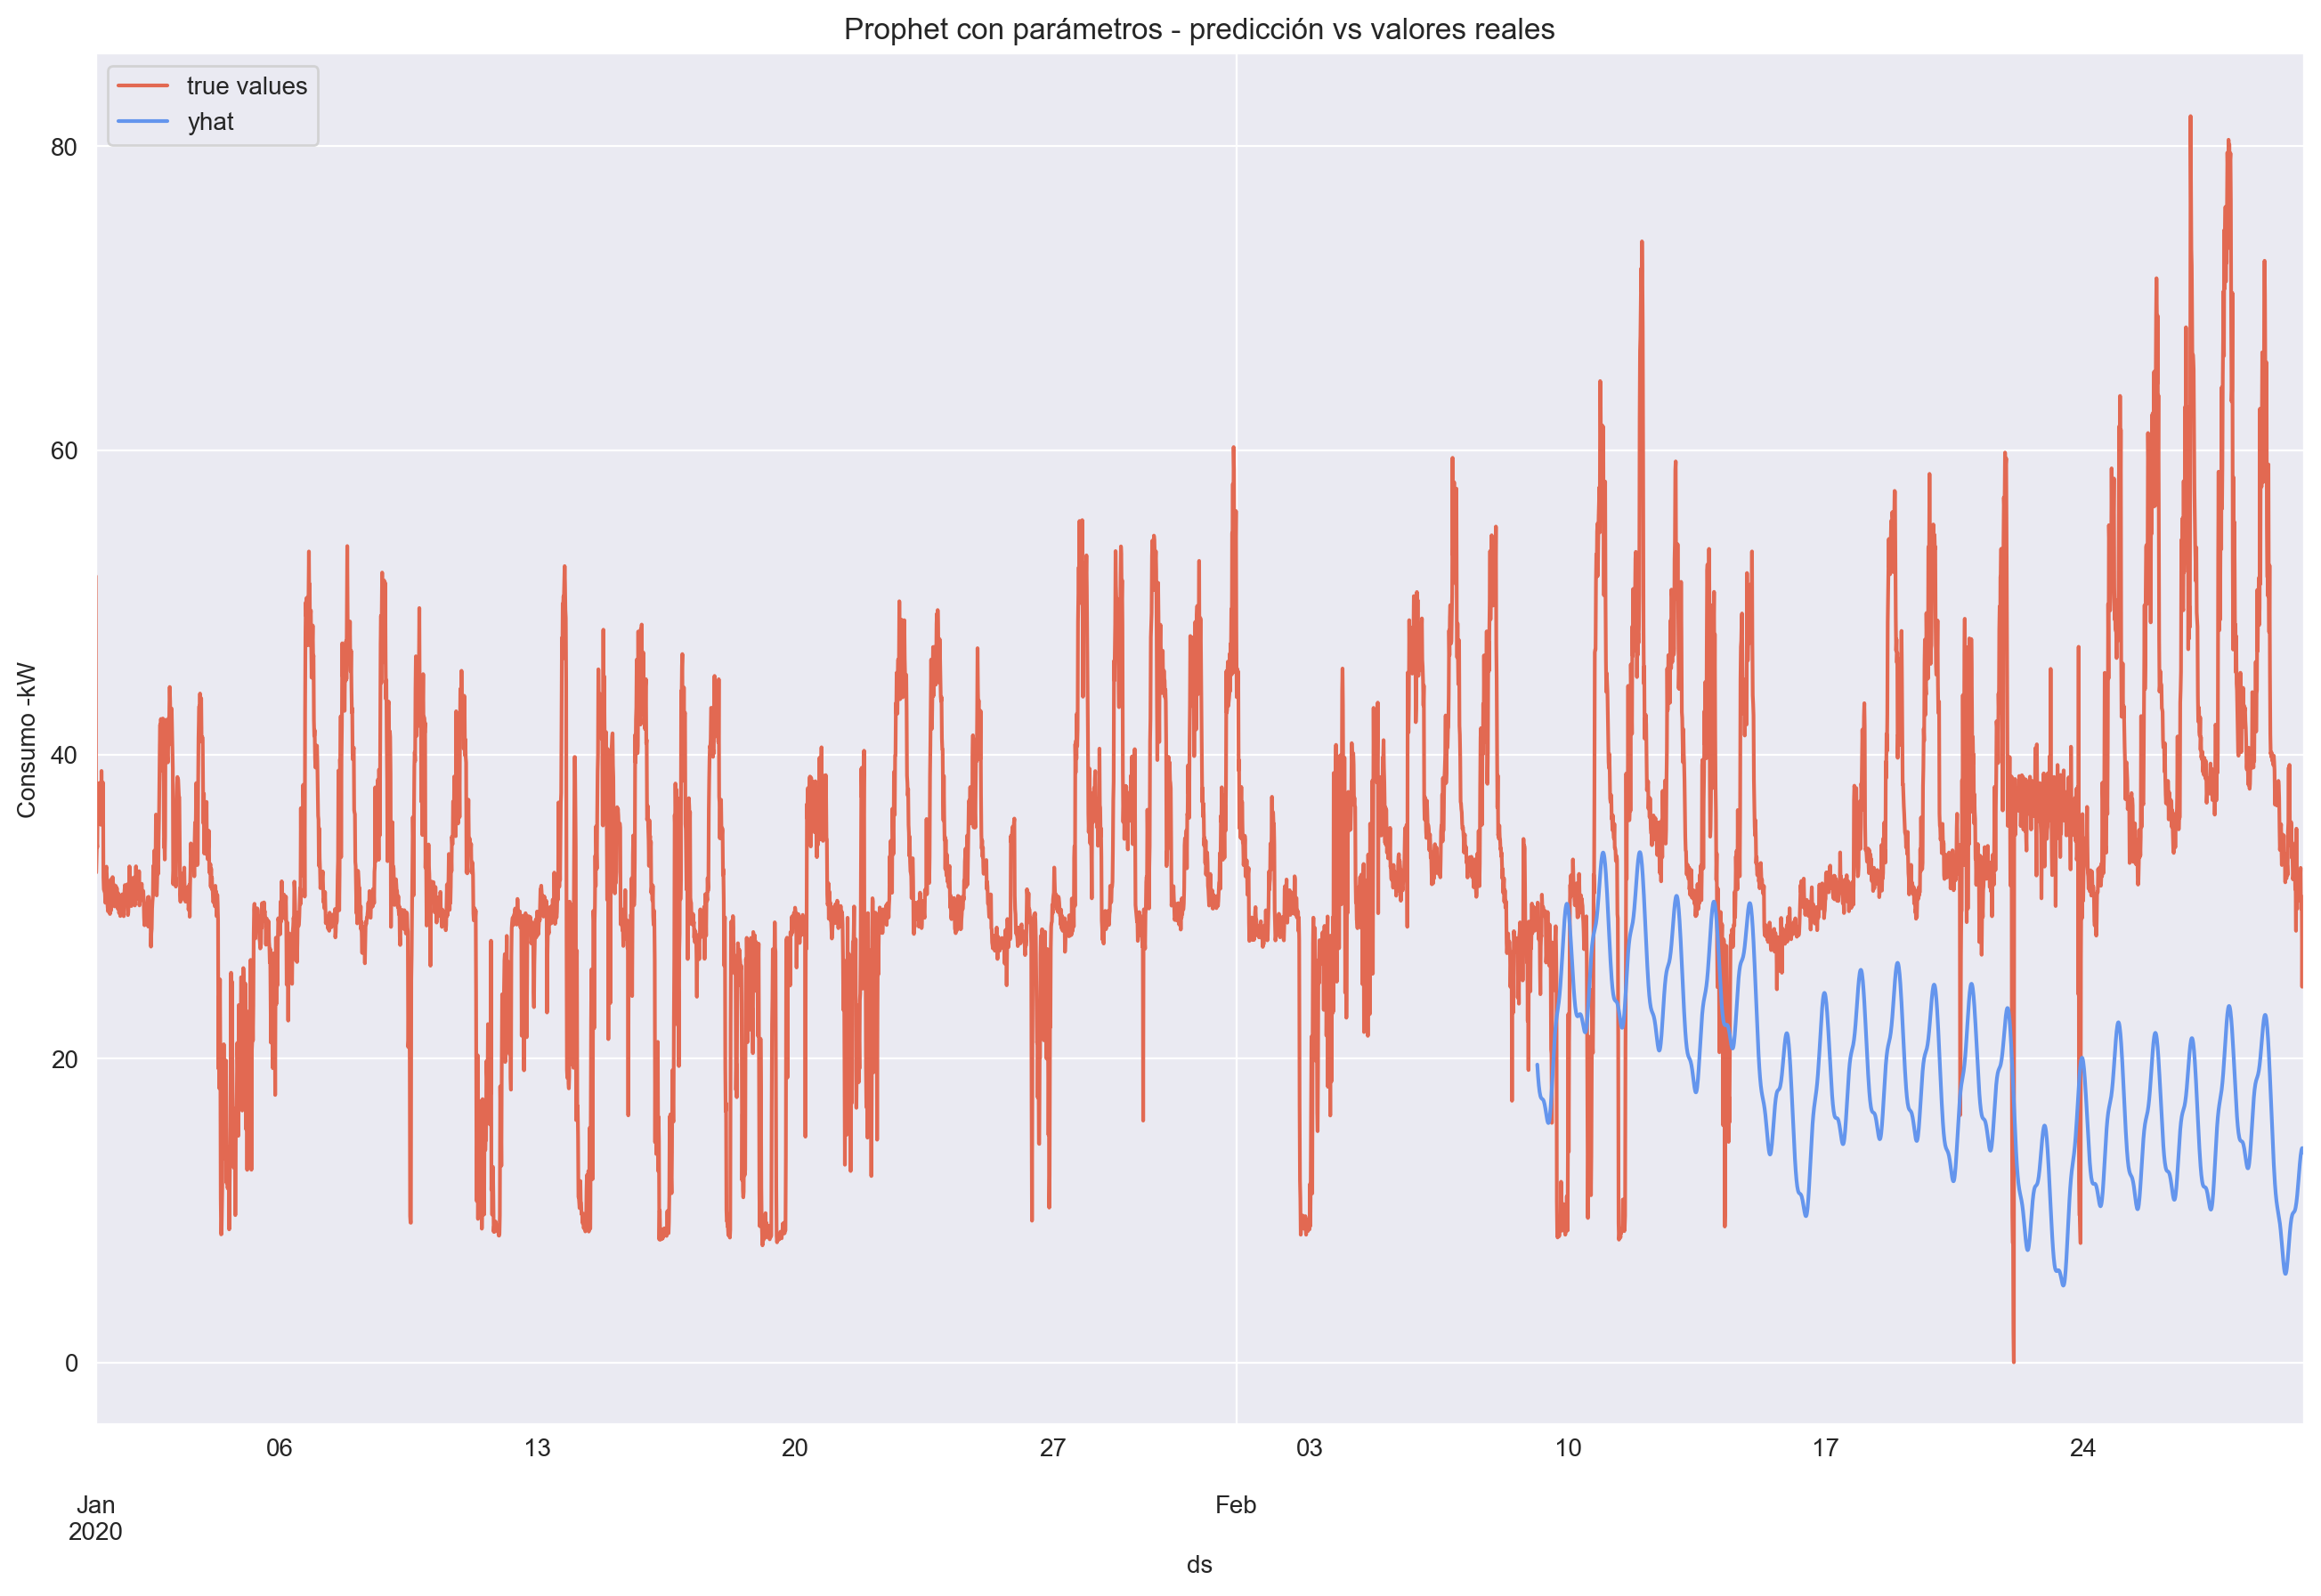

In [43]:
plt.figure(figsize=(16, 10), dpi=200)
df = energy_use
#Out of sample forecast
future = df_test_p[['ds']]
forecast = auto_model.predict(future)[['ds', 'yhat']].set_index('ds')
ax = df[df.index.year == 2020][var].plot(label='true values')
forecast.plot(label='predicted values', ax=ax, color='cornflowerblue')
plt.title('Prophet con parámetros - predicción vs valores reales')
plt.ylabel('Consumo -kW')
plt.legend()

#### Parameter tuning with log transformation

In [50]:
df_test_p['y_log'] = np.log(df_test_p['y'])
df_train_p['y_log'] = np.log(df_train_p['y'])


In [51]:
df_train_p_log = df_train_p[['ds', 'y_log']].rename(columns={'y_log': 'y'}).copy()
df_test_p_log = df_test_p[['ds', 'y_log']].rename(columns={'y_log': 'y'}).copy()

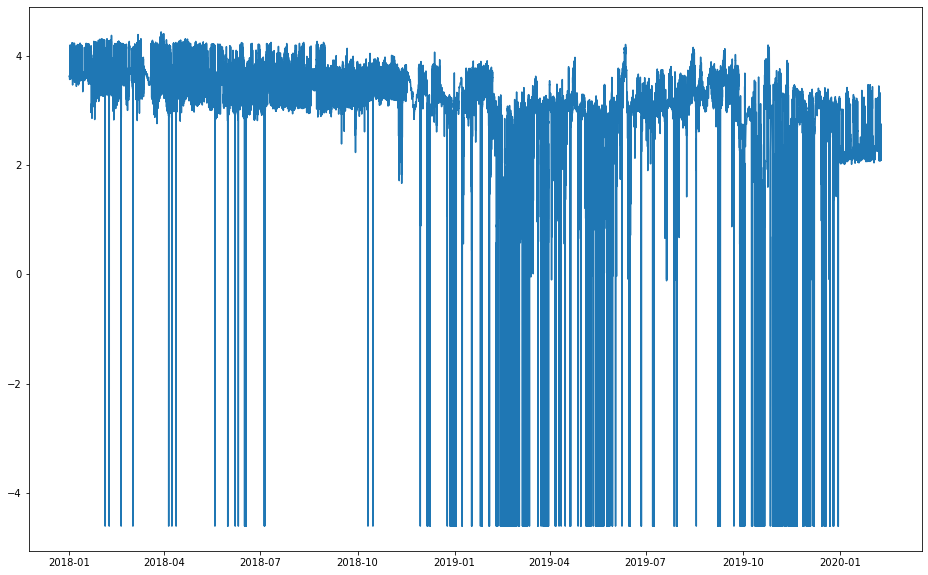

In [52]:
# We plot the new data
plt.figure(figsize=(16, 10))
plt.plot(df_train_p_log['ds'], df_train_p_log['y'], label='train')

In [57]:
df_p

horizon       mse      rmse       mae     mdape   smape  coverage
0 100 days  6.154361  2.480798  1.773504  0.444454  0.7009  0.763776

In [58]:

# Create a list to store MAPE values for each combination
mapes_log = [] 
# Use cross validation to evaluate all parameters
for params in all_params:
    # Fit a model using one parameter combination
    m = Prophet(**params).fit(df_train_p_log)  
    # Cross-validation
    df_cv = cross_validation(m, initial='370 days', period='80 days', horizon = '100 days', parallel="processes")
    # Model performance
    df_p = performance_metrics(df_cv, rolling_window=1)
    # Save model performance metrics
    mapes_log.append(df_p['smape'].values[0])
    
# Tuning results
tuning_results_log = pd.DataFrame(all_params)
tuning_results_log['smape'] = mapes_log
# Find the best parameters
best_params_log = all_params[np.argmin(mapes_log)]
print(best_params_log)

22:56:50 - cmdstanpy - INFO - Chain [1] start processing
22:56:55 - cmdstanpy - INFO - Chain [1] done processing
22:56:59 - cmdstanpy - INFO - Chain [1] start processing
22:57:00 - cmdstanpy - INFO - Chain [1] start processing
22:57:00 - cmdstanpy - INFO - Chain [1] start processing
22:57:01 - cmdstanpy - INFO - Chain [1] start processing
22:57:03 - cmdstanpy - INFO - Chain [1] done processing
22:57:05 - cmdstanpy - INFO - Chain [1] done processing
22:57:06 - cmdstanpy - INFO - Chain [1] done processing
22:57:06 - cmdstanpy - INFO - Chain [1] done processing
22:57:12 - cmdstanpy - INFO - Chain [1] start processing
22:57:15 - cmdstanpy - INFO - Chain [1] done processing
22:57:19 - cmdstanpy - INFO - Chain [1] start processing
22:57:19 - cmdstanpy - INFO - Chain [1] start processing
22:57:20 - cmdstanpy - INFO - Chain [1] start processing
22:57:20 - cmdstanpy - INFO - Chain [1] start processing
22:57:23 - cmdstanpy - INFO - Chain [1] done processing
22:57:24 - cmdstanpy - INFO - Chain [1

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


00:12:30 - cmdstanpy - INFO - Chain [1] start processing
00:12:33 - cmdstanpy - INFO - Chain [1] done processing
00:12:37 - cmdstanpy - INFO - Chain [1] start processing
00:12:37 - cmdstanpy - INFO - Chain [1] start processing
00:12:38 - cmdstanpy - INFO - Chain [1] start processing
00:12:38 - cmdstanpy - INFO - Chain [1] start processing
00:12:41 - cmdstanpy - INFO - Chain [1] done processing
00:12:42 - cmdstanpy - INFO - Chain [1] done processing
00:12:43 - cmdstanpy - INFO - Chain [1] done processing
00:12:44 - cmdstanpy - INFO - Chain [1] done processing


   horizon       mse      rmse       mae     mdape     smape  coverage
0 100 days  5.779219  2.404001  1.652964  0.380393  0.617623  0.846042


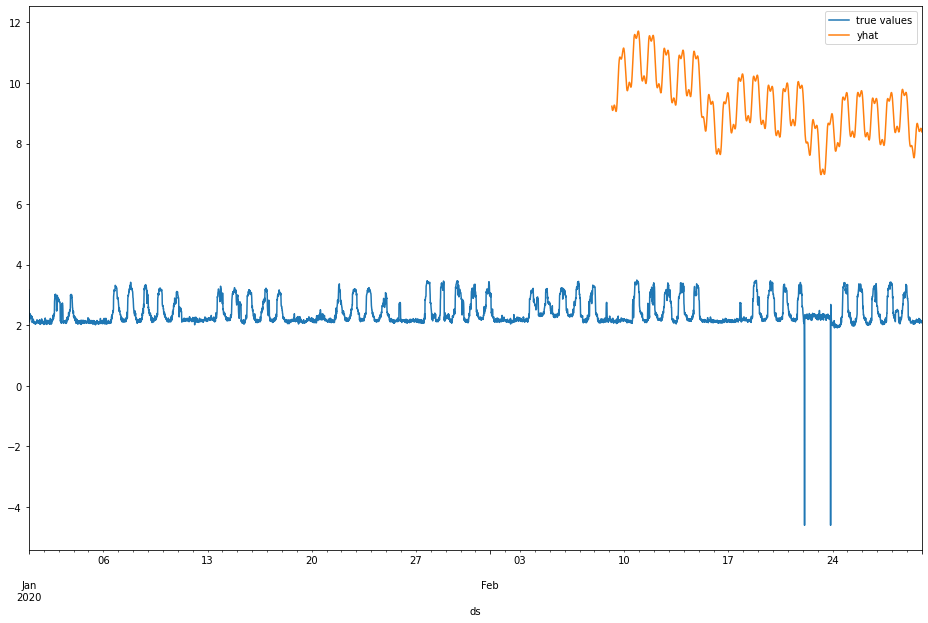

In [59]:
auto_model_log = Prophet(changepoint_prior_scale=0.001, 
                     seasonality_prior_scale=0.01, 
                     seasonality_mode='multiplicative')
# Fit the model on the training dataset
auto_model_log.fit(df_train_p_log)
# Cross validation
auto_model_log_cv = cross_validation(auto_model_log, initial='370 days', period='80 days', horizon = '100 days', parallel="processes")
# Model performance metrics
auto_model_log_p = performance_metrics(auto_model_log_cv, rolling_window=1)

print(auto_model_log_p)
plt.figure(figsize=(16, 10))
df = energy_use
#Out of sample forecast
future = df_test_p_log[['ds']]
forecast = auto_model.predict(future)[['ds', 'yhat']].set_index('ds')
ax = np.log(df[df.index.year == 2020][var]).plot(label='true values')
forecast.plot(label='predicted values', ax=ax)
plt.legend()

#### Box-Cox transformation

We want to check if the optimal box-cox transformation is the log transformation, which we have already tried. 

In [44]:
from scipy.stats import boxcox

box_cox_df,lam = boxcox(energy_use[var])
print('Lambda: %f' % lam)


Lambda: 0.704296


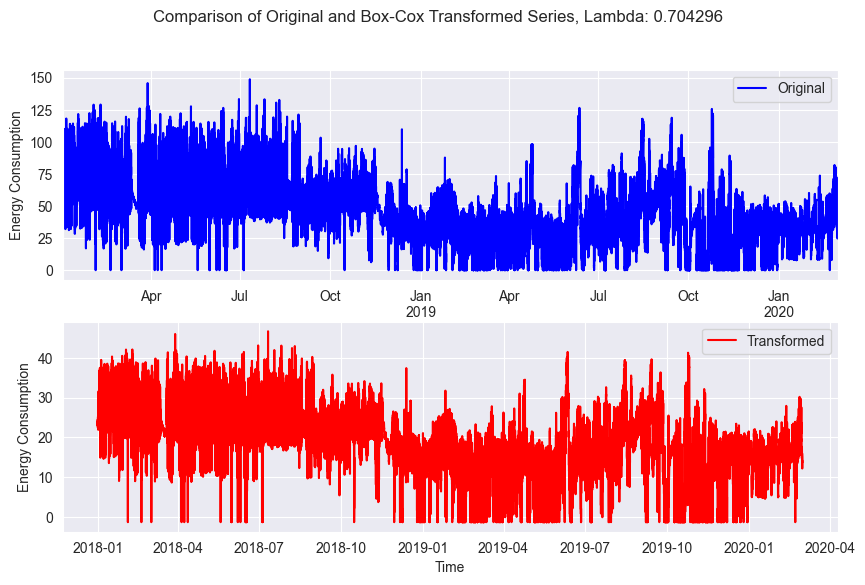

In [45]:
fig, ax = plt.subplots(2,1,figsize=(10,6))

# plot the original series
energy_use[var].plot(ax=ax[0], color='blue', label='Original')

# plot the transformed series
sns.lineplot(ax=ax[1],y=box_cox_df, x=energy_use[var].index, color='red', label='Transformed')

# set the axis labels and title
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Energy Consumption')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Energy Consumption')
plt.suptitle('Comparison of Original and Box-Cox Transformed Series, Lambda: %f' % lam)

# add a legend
ax[0].legend()

# show the plot
plt.show()

In [46]:
box_cox_df = pd.DataFrame(box_cox_df, columns=[var], index=energy_use.index)
box_cox_train = box_cox_df.iloc[:-2000,:][[var]].reset_index().rename(columns={var: 'y', 'date':'ds'})
box_cox_test = box_cox_df.iloc[-2000:, :][[var]].reset_index().rename(columns={var: 'y', 'date':'ds'})

19:00:12 - cmdstanpy - INFO - Chain [1] start processing
19:00:15 - cmdstanpy - INFO - Chain [1] done processing
19:00:18 - cmdstanpy - INFO - Chain [1] start processing
19:00:19 - cmdstanpy - INFO - Chain [1] start processing
19:00:19 - cmdstanpy - INFO - Chain [1] start processing
19:00:19 - cmdstanpy - INFO - Chain [1] start processing
19:00:25 - cmdstanpy - INFO - Chain [1] done processing
19:00:25 - cmdstanpy - INFO - Chain [1] done processing
19:00:27 - cmdstanpy - INFO - Chain [1] done processing
19:00:28 - cmdstanpy - INFO - Chain [1] done processing


   horizon        mse      rmse      mae      mape     mdape     smape  \
0 100 days  85.257207  9.233483  7.46031  5.358519  0.400223  0.639146   

   coverage  
0  0.533542  


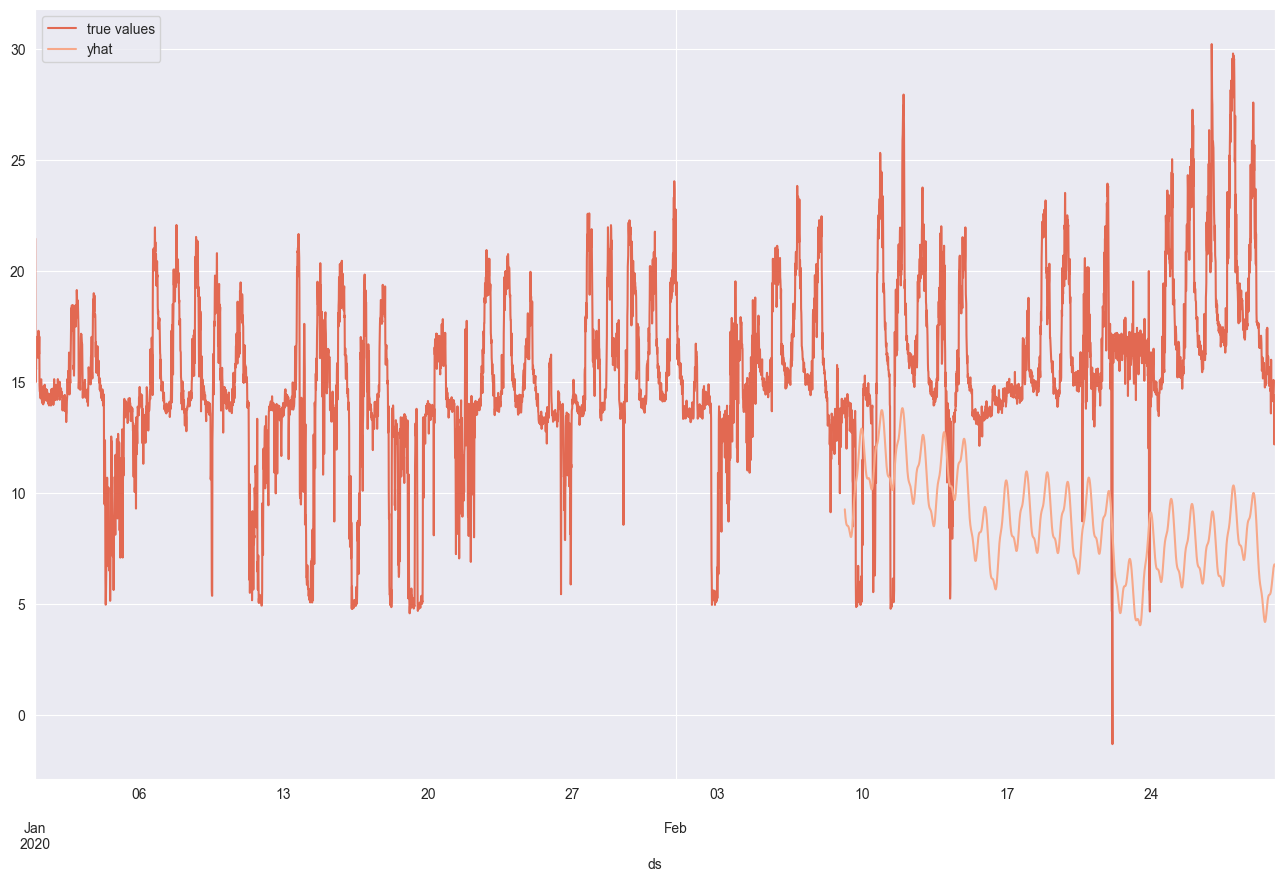

In [47]:
auto_model_bc = auto_model = Prophet(changepoint_prior_scale=0.001, 
                     seasonality_prior_scale=0.01, 
                     seasonality_mode='additive')

auto_model_bc.add_seasonality(name='hourly', period=4, fourier_order=3)
# Fit the model on the training dataset
auto_model_bc.fit(box_cox_train)
# Cross validation
auto_model_bc_cv = cross_validation(auto_model_bc, initial='370 days', period='80 days', horizon = '100 days', parallel="processes")
# Model performance metrics
auto_model_bc_p = performance_metrics(auto_model_bc_cv, rolling_window=1)

print(auto_model_bc_p)
plt.figure(figsize=(16, 10))
df = box_cox_df
#Out of sample forecast
future = box_cox_test[['ds']]
forecast = auto_model_bc.predict(future)[['ds', 'yhat']].set_index('ds')
ax = df[df.index.year == 2020][var].plot(label='true values')
forecast.plot(label='predicted values', ax=ax)
plt.legend()

### TBATS model


The TBATS algorithm decomposes a time series into several components, including the trend component, multiple seasonal components (with different frequencies and phases), and the stochastic component. It then applies a Box-Cox transformation to the data to ensure the stability of the variance and allows for non-linear transformations of the data. The trigonometric seasonality component uses a Fourier series to model the periodic patterns in the data, which can capture both harmonic and non-harmonic seasonalities. Finally, the algorithm models the stochastic component using an ARMA (autoregressive moving average) model with errors that are assumed to be normally distributed.

In [14]:
from tbats import TBATS, BATS
# Fit the model
estimator = TBATS(seasonal_periods=(4,96, 96*7),use_box_cox=False)
model = estimator.fit(df_train)
# Forecast 365 days ahead


In [15]:
y_forecast=model.forecast(steps=2000)

In [16]:

results_tbats_df = pd.DataFrame(df_test)
results_tbats_df['forecast'] = y_forecast

In [17]:
df_test.shape

(2000,)

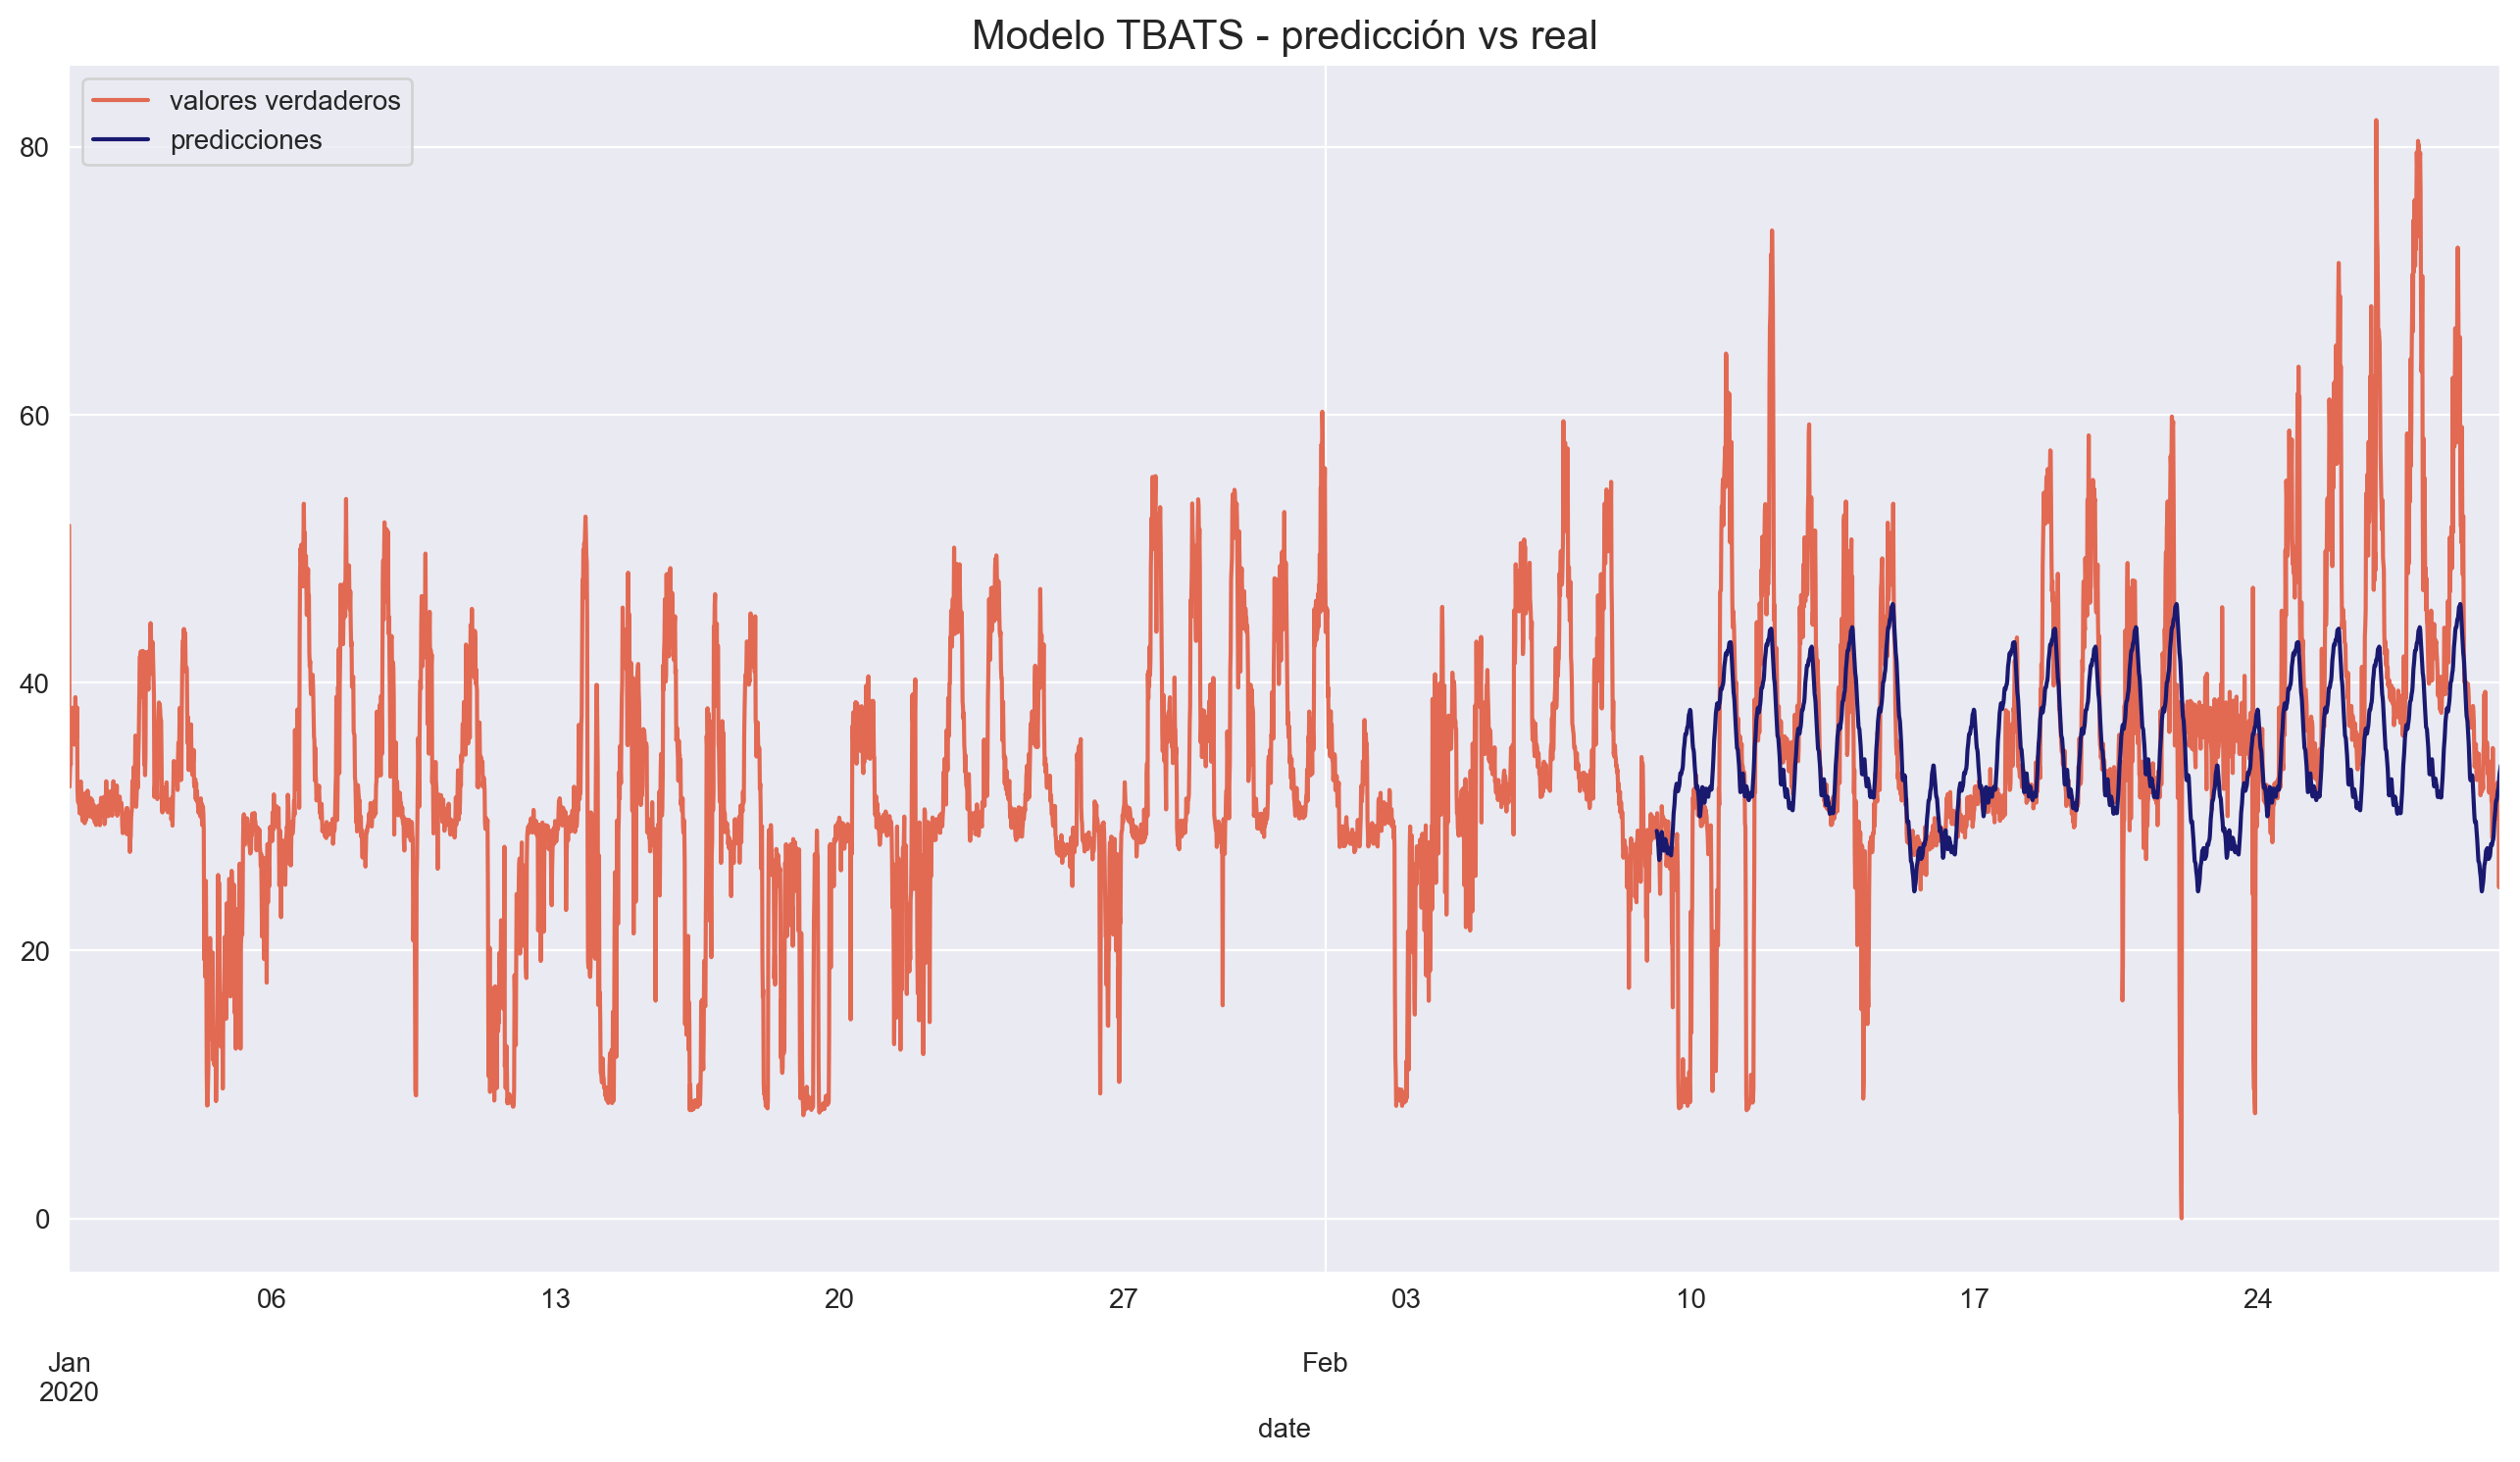

In [28]:
plt.figure(figsize=(16, 8), dpi=200)
df = energy_use
#Out of sample forecast
ax = df[df.index.year == 2020][var].plot(label='valores verdaderos')
results_tbats_df['forecast'].plot(label='predicciones', ax=ax, color='midnightblue')
plt.title("Modelo TBATS - predicción vs real", fontsize=15)
plt.legend()

In [22]:
metrics2(y_forecast, df_test)

TRAIN SET METRICS
mae: 6.666741865899408
mape: 1.224016033848222
rmse: 9.670482684448423


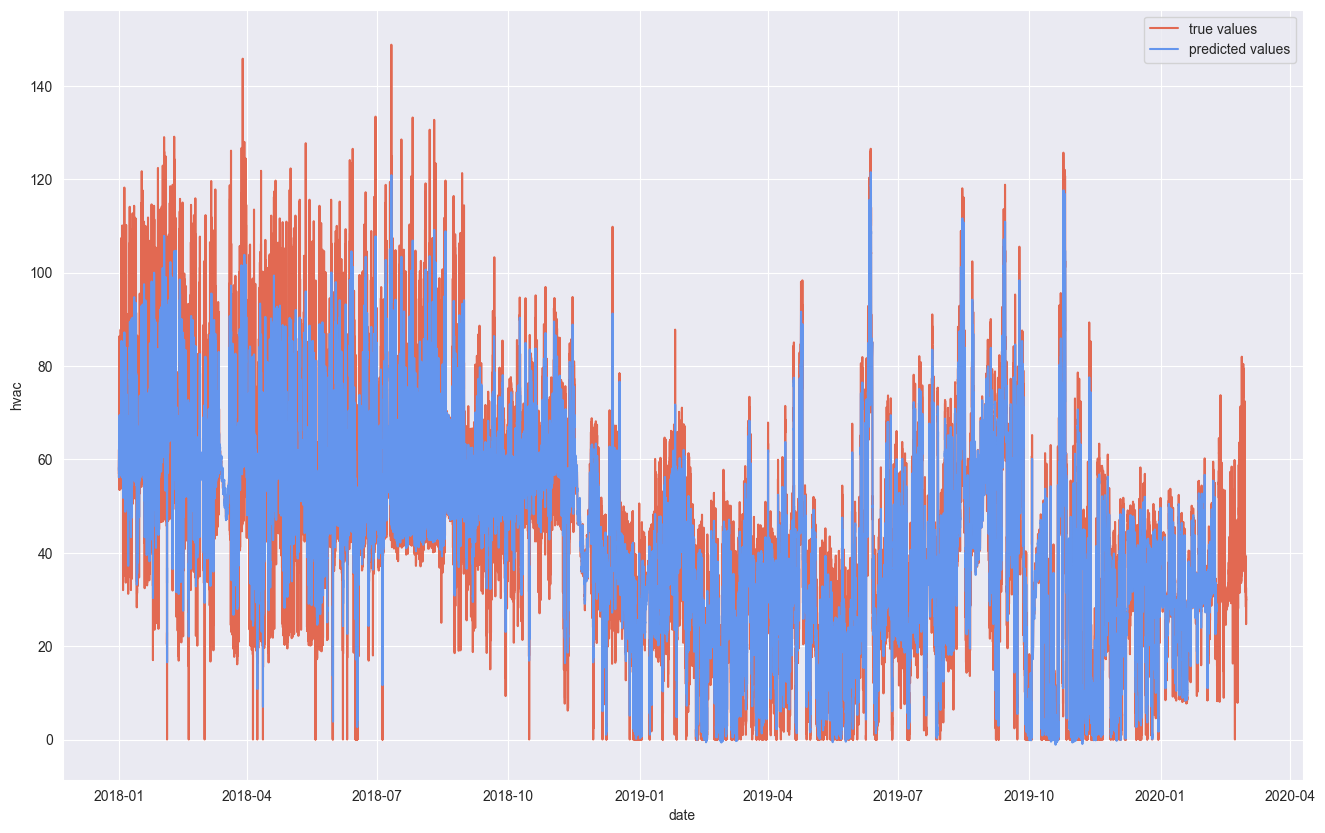

In [24]:
#We check in sample forecasts
plt.figure(figsize=(16, 10))
#Out of sample forecast
sns.lineplot(x=energy_use.index, y=energy_use[var], label='true values')
sns.lineplot(y=model.y_hat, x=df_train.index, label='predicted values', color='cornflowerblue')
plt.legend()


In [76]:
metrics2(model.y_hat, df_train, text='TRAIN')

TRAIN SET METRICS
mae: 3.478989181279551
mape: 14.244667517854378
rmse: 5.685955841315253


In [25]:

# Reading model parameters
print(model.params.alpha)
print(model.params.beta)
print(model.params.x0)
print(model.params.components.use_box_cox)
print(model.params.components.seasonal_harmonics)

0.36095706384322823
-0.010294703103954373
[ 5.66402018e+01  5.41984746e-01  1.08275557e-01 -3.95289794e-02
  3.77019340e+00  4.30024113e-01  5.41739845e-01 -1.46493046e-01
  1.65173752e-01 -1.89635116e-01  8.61444986e-02 -1.17959464e-02
 -5.29845053e-02 -1.78899162e-01 -6.82589199e-02 -3.50517144e+00
 -5.19868310e-01 -7.58613395e-01  1.83170910e-01 -1.27881506e-01
 -9.26516433e-02 -1.74380829e-01 -8.34490327e-02  1.96931051e-01
  1.39961718e-01 -1.87180321e-01 -2.10506035e+00 -2.89223953e-01
  1.32037626e+00  1.64010252e-01 -1.27390586e+00 -1.18708732e+00
  1.82014436e+00  2.61453426e+00  2.89073219e-01 -7.19517976e-01
 -2.46816416e-01  7.20657006e-01]
False
[ 1 11  6]


In [26]:
print(model.params.components.summary())

Use Box-Cox: False
Use trend: True
Use damped trend: True
Seasonal periods: [  4.  96. 672.]
Seasonal harmonics [ 1 11  6]
ARMA errors (p, q): (0, 0)



## 2. Models on grouped variable 

Since fitting the model on the full variable did not work well, we are going to compare the behaviour of the same models, except this time we will be resampling the series and check the results.

In [11]:
# Importamos csv
energy_use['hour'] = energy_use.index.to_period("h")

energy_grouped = energy_use.groupby('hour').mean()
energy_grouped.index = energy_grouped.index.to_timestamp()

In [12]:
var = 'hvac_N'

Text(0.5, 1.0, 'Energía utilizada en el ala sur')

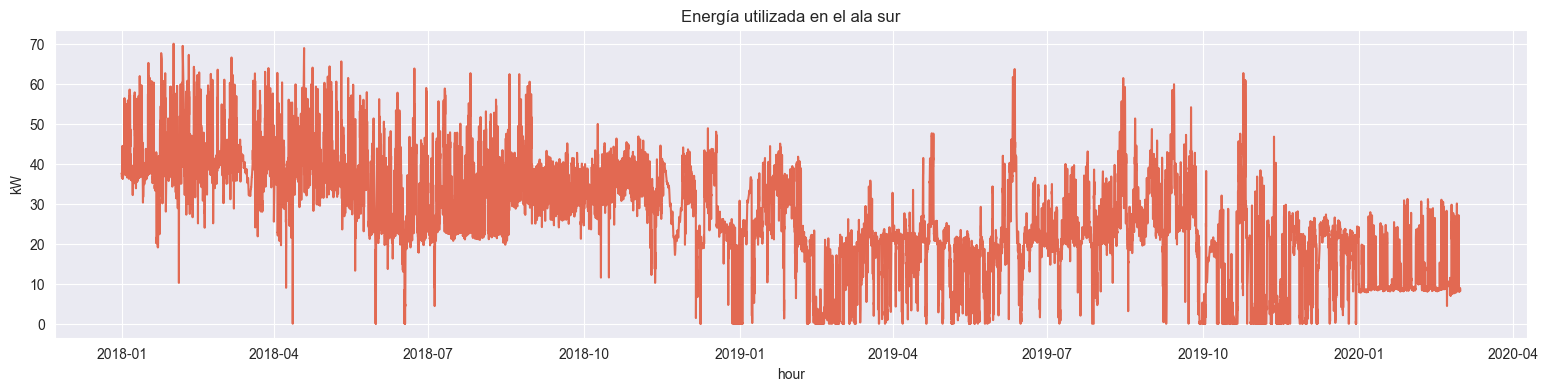

In [13]:
plt.figure(figsize=(19,4))
sns.lineplot(x =energy_grouped.index , y=energy_grouped[var])
plt.ylabel('kW')

plt.title('Energía utilizada en el ala sur')

Text(0.5, 1.0, 'Energía utilizada en el ala sur- diff')

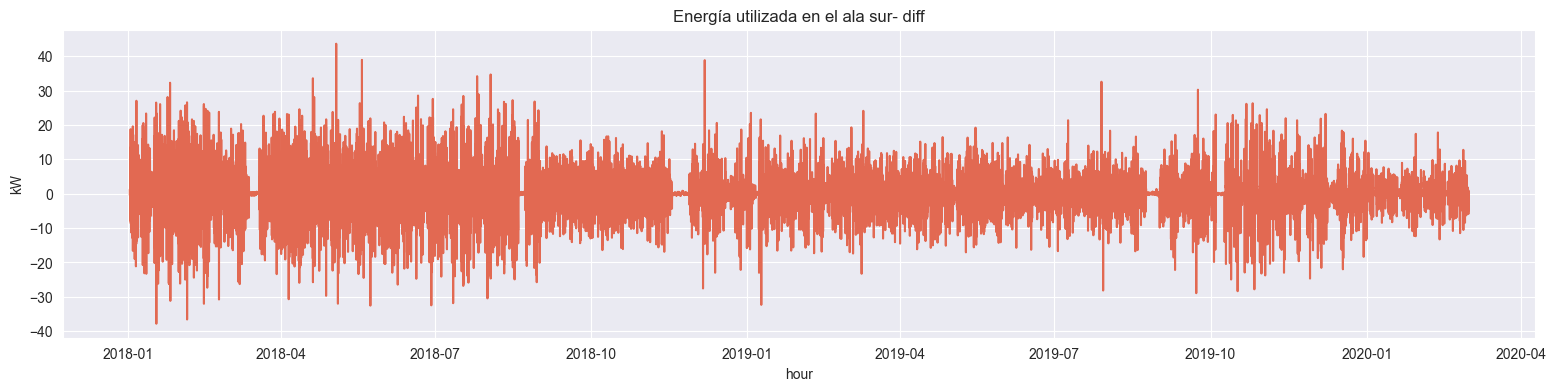

In [14]:
diff = energy_grouped[var]-energy_grouped[var].shift(1)
diff = (diff-diff.shift(24)).dropna()
plt.figure(figsize=(19,4))
sns.lineplot(x =diff.index , y=diff)
plt.ylabel('kW')

plt.title('Energía utilizada en el ala sur- diff')

In [15]:
n = energy_grouped.shape[0]

In [16]:

df_train_grouped = energy_grouped.iloc[:-int(n*0.15),:][var]
df_test_grouped = energy_grouped.iloc[-int(n*0.15):, :][var]

In [17]:
df_train_grouped.shape

(16116,)

In [18]:
df_test_grouped.shape

(2843,)

### SARIMAX

#### Simple SARIMAX

In [24]:
sarimax_mod = sm.tsa.statespace.SARIMAX(df_train_grouped,order=(2,1,3),
                                                seasonal_order=(0,0,1,24*7),
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

sarimax_fit = sarimax_mod.fit(maxiter=50) 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.84014D+00    |proj g|=  2.52873D-01

At iterate    5    f=  2.83002D+00    |proj g|=  2.97138D-02

At iterate   10    f=  2.82932D+00    |proj g|=  2.09828D-02

At iterate   15    f=  2.82817D+00    |proj g|=  7.18830D-03

At iterate   20    f=  2.82813D+00    |proj g|=  9.84383D-04

At iterate   25    f=  2.82812D+00    |proj g|=  1.98832D-03

At iterate   30    f=  2.82804D+00    |proj g|=  7.43446D-03

At iterate   35    f=  2.82760D+00    |proj g|=  1.37873D-01

At iterate   40    f=  2.82610D+00    |proj g|=  1.55523D-01

At iterate   45    f=  2.82474D+00    |proj g|=  2.33920D-02


/Users/maguado/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.82430D+00    |proj g|=  1.26311D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     82      1     0     0   1.263D-02   2.824D+00
  F =   2.8243003960920365     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


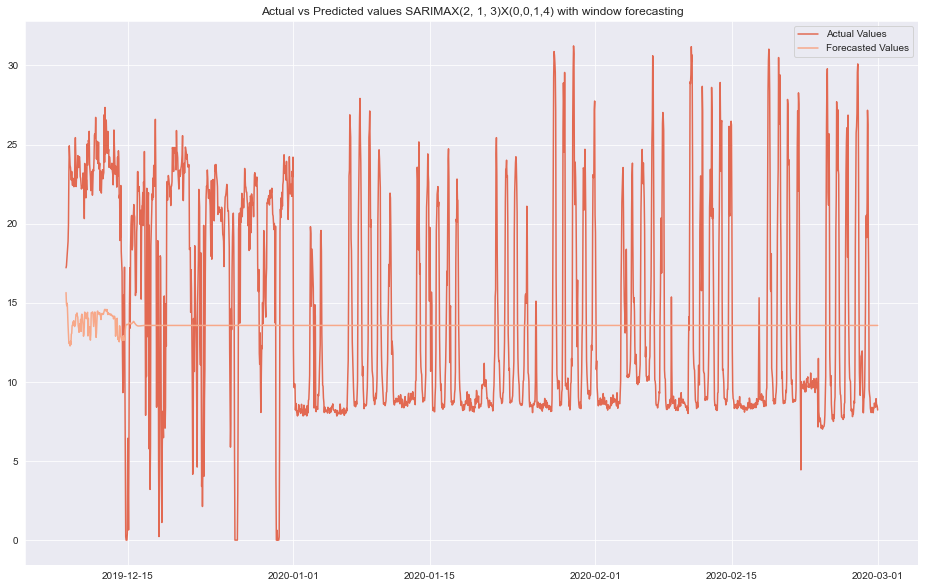

In [31]:
forecasts = sarimax_fit.forecast(steps = len(df_test_grouped))
actuals = df_test_grouped
# Plot the forecasts and actual values
plt.figure(figsize=(16, 10))
plt.plot(actuals, label='Actual Values')
plt.plot(forecasts, label='Forecasted Values')
plt.title('Actual vs Predicted values SARIMAX(2, 1, 3)X(0,0,1,4) with window forecasting')
plt.legend()
plt.show()

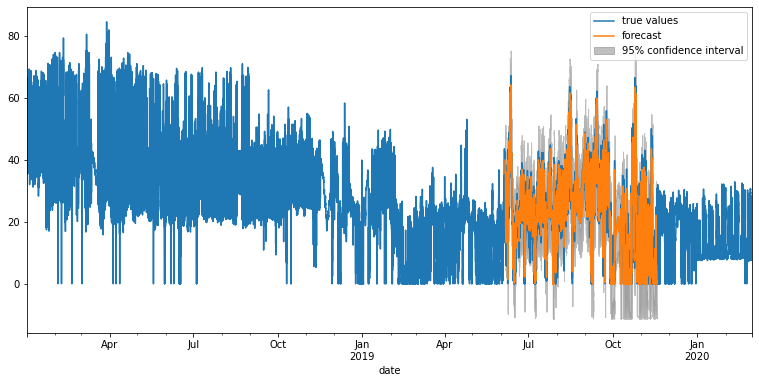

In [ ]:

# Actual vs Fitte
fig, ax = plt.subplots(figsize=(13,6))

ax = energy_use[var].plot(label ='true values', ax=ax)

fig = plot_predict(sarimax_fit, start = start, end = end, ax = ax)
#ax.set_xlim(['2019-01', '2019-02'])
plt.legend()
plt.show()

Next, we will compare the MSE of both models:

In [32]:
metrics(sarimax_fit, df_test_grouped, df_train_grouped)

TRAIN SET METRICS
mae: 2.7740907120230927
mape: 7.309622412643849
rmse: 4.362032551843374
TEST SET METRICS
mae: 5.972844951088385
mape: 11.431650513300937
rmse: 6.783432732475188


#### SARIMAX with exogenous variable

In [18]:
from pmdarima.preprocessing import FourierFeaturizer


In [19]:
# prepare Fourier terms
exog = pd.DataFrame({'date': energy_grouped.index})



In [64]:
four_terms = FourierFeaturizer(24*7, 1)
y_prime, exog = four_terms.fit_transform(energy_grouped[var])
exog['date'] = y_prime.index # is exactly the same as manual calculation in the above cells
exog = exog.set_index(exog['date'])
exog.index.freq = 'H'
exog = exog.drop(columns=['date'])


In [65]:
exog_to_train_grouped = exog.iloc[:-2000,:]
exog_to_test_grouped = exog.iloc[-2000:, :]


In [66]:
assert exog_to_train_grouped.shape[0] == df_train_grouped.shape[0]

In [34]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

sf = AutoARIMA(season_length = 24)

sf.fit(df_train_grouped.values, exog_to_train_grouped.values)


AutoARIMA

In [39]:
forecasts = sf.predict(len(df_test_grouped), exog_to_test_grouped.values)['mean']


In [61]:
sf.model_

{'coef': {'ar1': 0.07599486253552212,
  'ma1': -0.3090364190975562,
  'sma1': 0.10830568283348761,
  'sma2': 0.06494360086206351,
  'ex_1': 0.9487748457170038,
  'ex_2': -1.2665940632510406},
 'sigma2': 18.384085682294575,
 'var_coef': array([[3.43679486e-09, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 3.47736868e-09, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 3.47736868e-09, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.47736868e-09,
         0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         3.47736868e-09, 3.27277569e-26],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         1.88718598e-26, 3.47736868e-09]]),
 'mask': array([ True,  True,  True,  True,  True,  True]),
 'loglik': -4

In [43]:
results = pd.DataFrame(df_test_grouped)
results['forecast']=forecasts

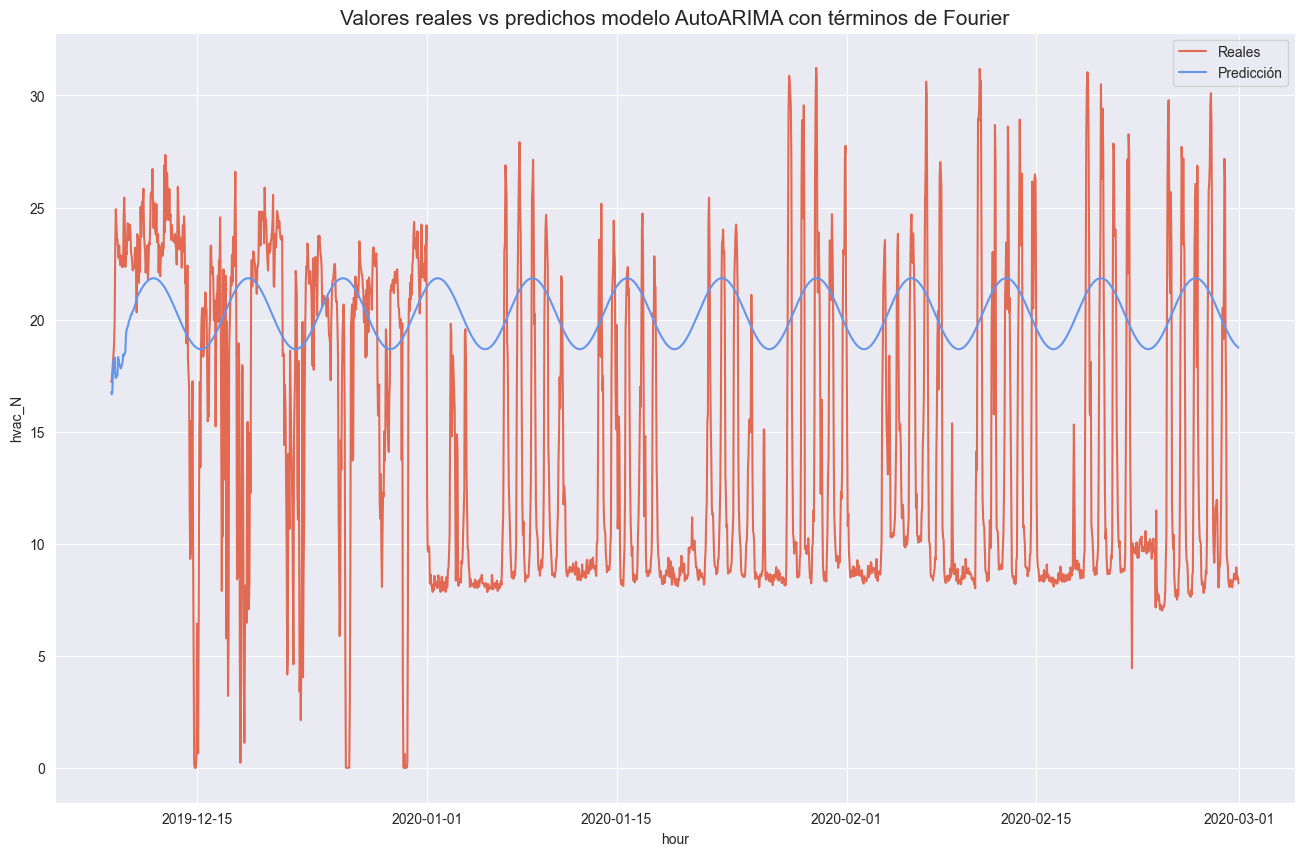

In [54]:
actuals = df_test_grouped
# Plot the forecasts and actual valuesb
plt.figure(figsize=(16, 10))
sns.lineplot(x=results.index, y=results[var], label='Reales')
sns.lineplot(x=results.index, y=results['forecast'], label='Predicción', color='cornflowerblue')

plt.title('Valores reales vs predichos modelo AutoARIMA con términos de Fourier', fontsize=15)
plt.legend()
plt.show()

#### SARIMAX with window forecasting

In [70]:
df_train_grouped.shape

(16959,)

In [71]:
exog_to_train_grouped.shape

(16959, 2)

In [72]:
# We will make 24 forecasts (day) and then retrain the model with PREDICTED VALUES, and repeat this process 7 times (to forecast an entire week)

# Set the number of forecasts to make
n_forecasts = 24

# Set the number of iterations to perform
n_iter = 7

# Initialize lists to store the forecasts and actual values
forecasts = []
actuals = []

train_2 = df_train_grouped.copy()

forecast = sf.predict(n_forecasts, exog_to_train_grouped[:n_forecasts].values)['mean']
forecasts.extend(forecast)

actuals.extend(df_train_grouped[:n_forecasts])
y = df_test_grouped[:n_forecasts]
X = exog_to_test_grouped[:n_forecasts]
X_future=exog_to_train_grouped[n_forecasts:2*n_forecasts]
model_extended=sf
# Loop through the iterations
for i in range(n_iter):
    index = i*n_forecasts
    
    # Forward the autoARIMA model on the next observations
    forecast = model_extended.forward(y=y.values, X=X.values,h=n_forecasts, X_future=X_future.values)['mean']

    forecasts.extend(forecast)

    actuals.extend(df_train_grouped[index:index+n_forecasts])
    y = df_test_grouped[index:index+n_forecasts]
    X = exog_to_test_grouped[index:index+n_forecasts]
    X_future=exog_to_train_grouped[index+n_forecasts:index+2*n_forecasts]








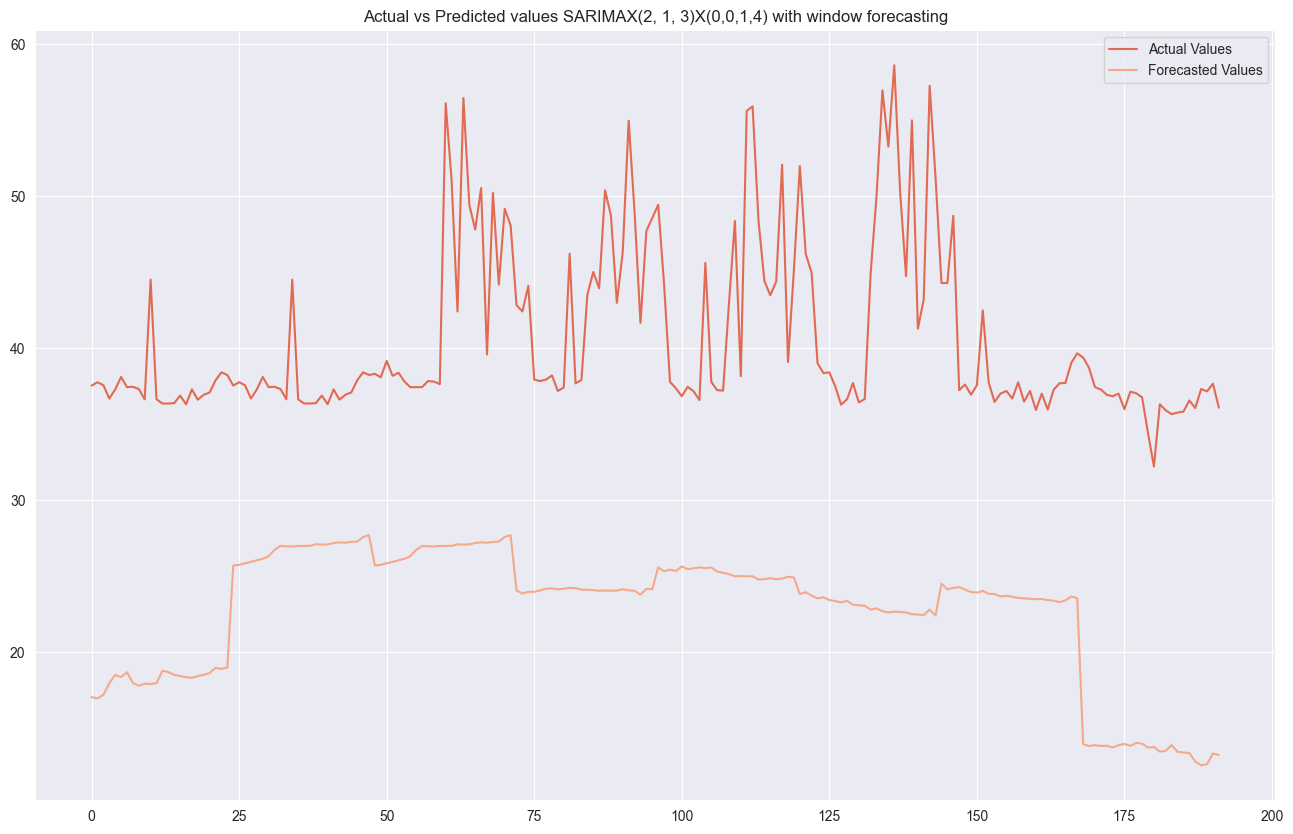

In [74]:

# Plot the forecasts and actual values
plt.figure(figsize=(16, 10))
plt.plot(actuals, label='Actual Values')
plt.plot(forecasts, label='Forecasted Values')
plt.title('Actual vs Predicted values SARIMAX(2, 1, 3)X(0,0,1,4) with window forecasting')
plt.legend()
plt.show()

In [75]:
metrics2(forecasts, actuals)

TRAIN SET METRICS
mae: 17.95812196473665
mape: 0.43695911203784094
rmse: 18.92203878779973


### Unobserved Components

In [56]:
from statsmodels.tsa.statespace.structural import UnobservedComponents

model_UC_grouped = sm.tsa.UnobservedComponents(df_train_grouped,
                                        level='lldtrend',
                                        irregular=True,
                                        stochastic_level = False,
                                        stochastic_trend = False,
                                        stochastic_freq_seasonal = [False, False, False],
                                        freq_seasonal=[{'period': 24, 'harmonics': 3},
                                                       {'period': 24*30, 'harmonics': 5},
                                                       {'period': 24*7, 'harmonics': 2}])
#fitting model to train data
model_UC1res_g = model_UC_grouped.fit()

#printing statsmodels summary for model
print(model_UC1res_g.summary())


/Users/maguado/miniconda/lib/python3.10/site-packages/statsmodels/tsa/statespace/structural.py:426: SpecificationWarning: Value of `irregular` may be overridden when the trend component is specified using a model string.
  warn("Value of `%s` may be overridden when the trend"


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58136D+00    |proj g|=  5.77055D-02


 This problem is unconstrained.



At iterate    5    f=  2.86951D+00    |proj g|=  3.84491D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     14      1     0     0   2.481D-06   2.870D+00
  F =   2.8695053716387409     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                               Unobserved Components Results                                
Dep. Variable:                               hvac_N   No. Observations:                16116
Model:             local linear deterministic trend   Log Likelihood              -46244.949
                             + freq_seasonal(24(3))   AIC                         

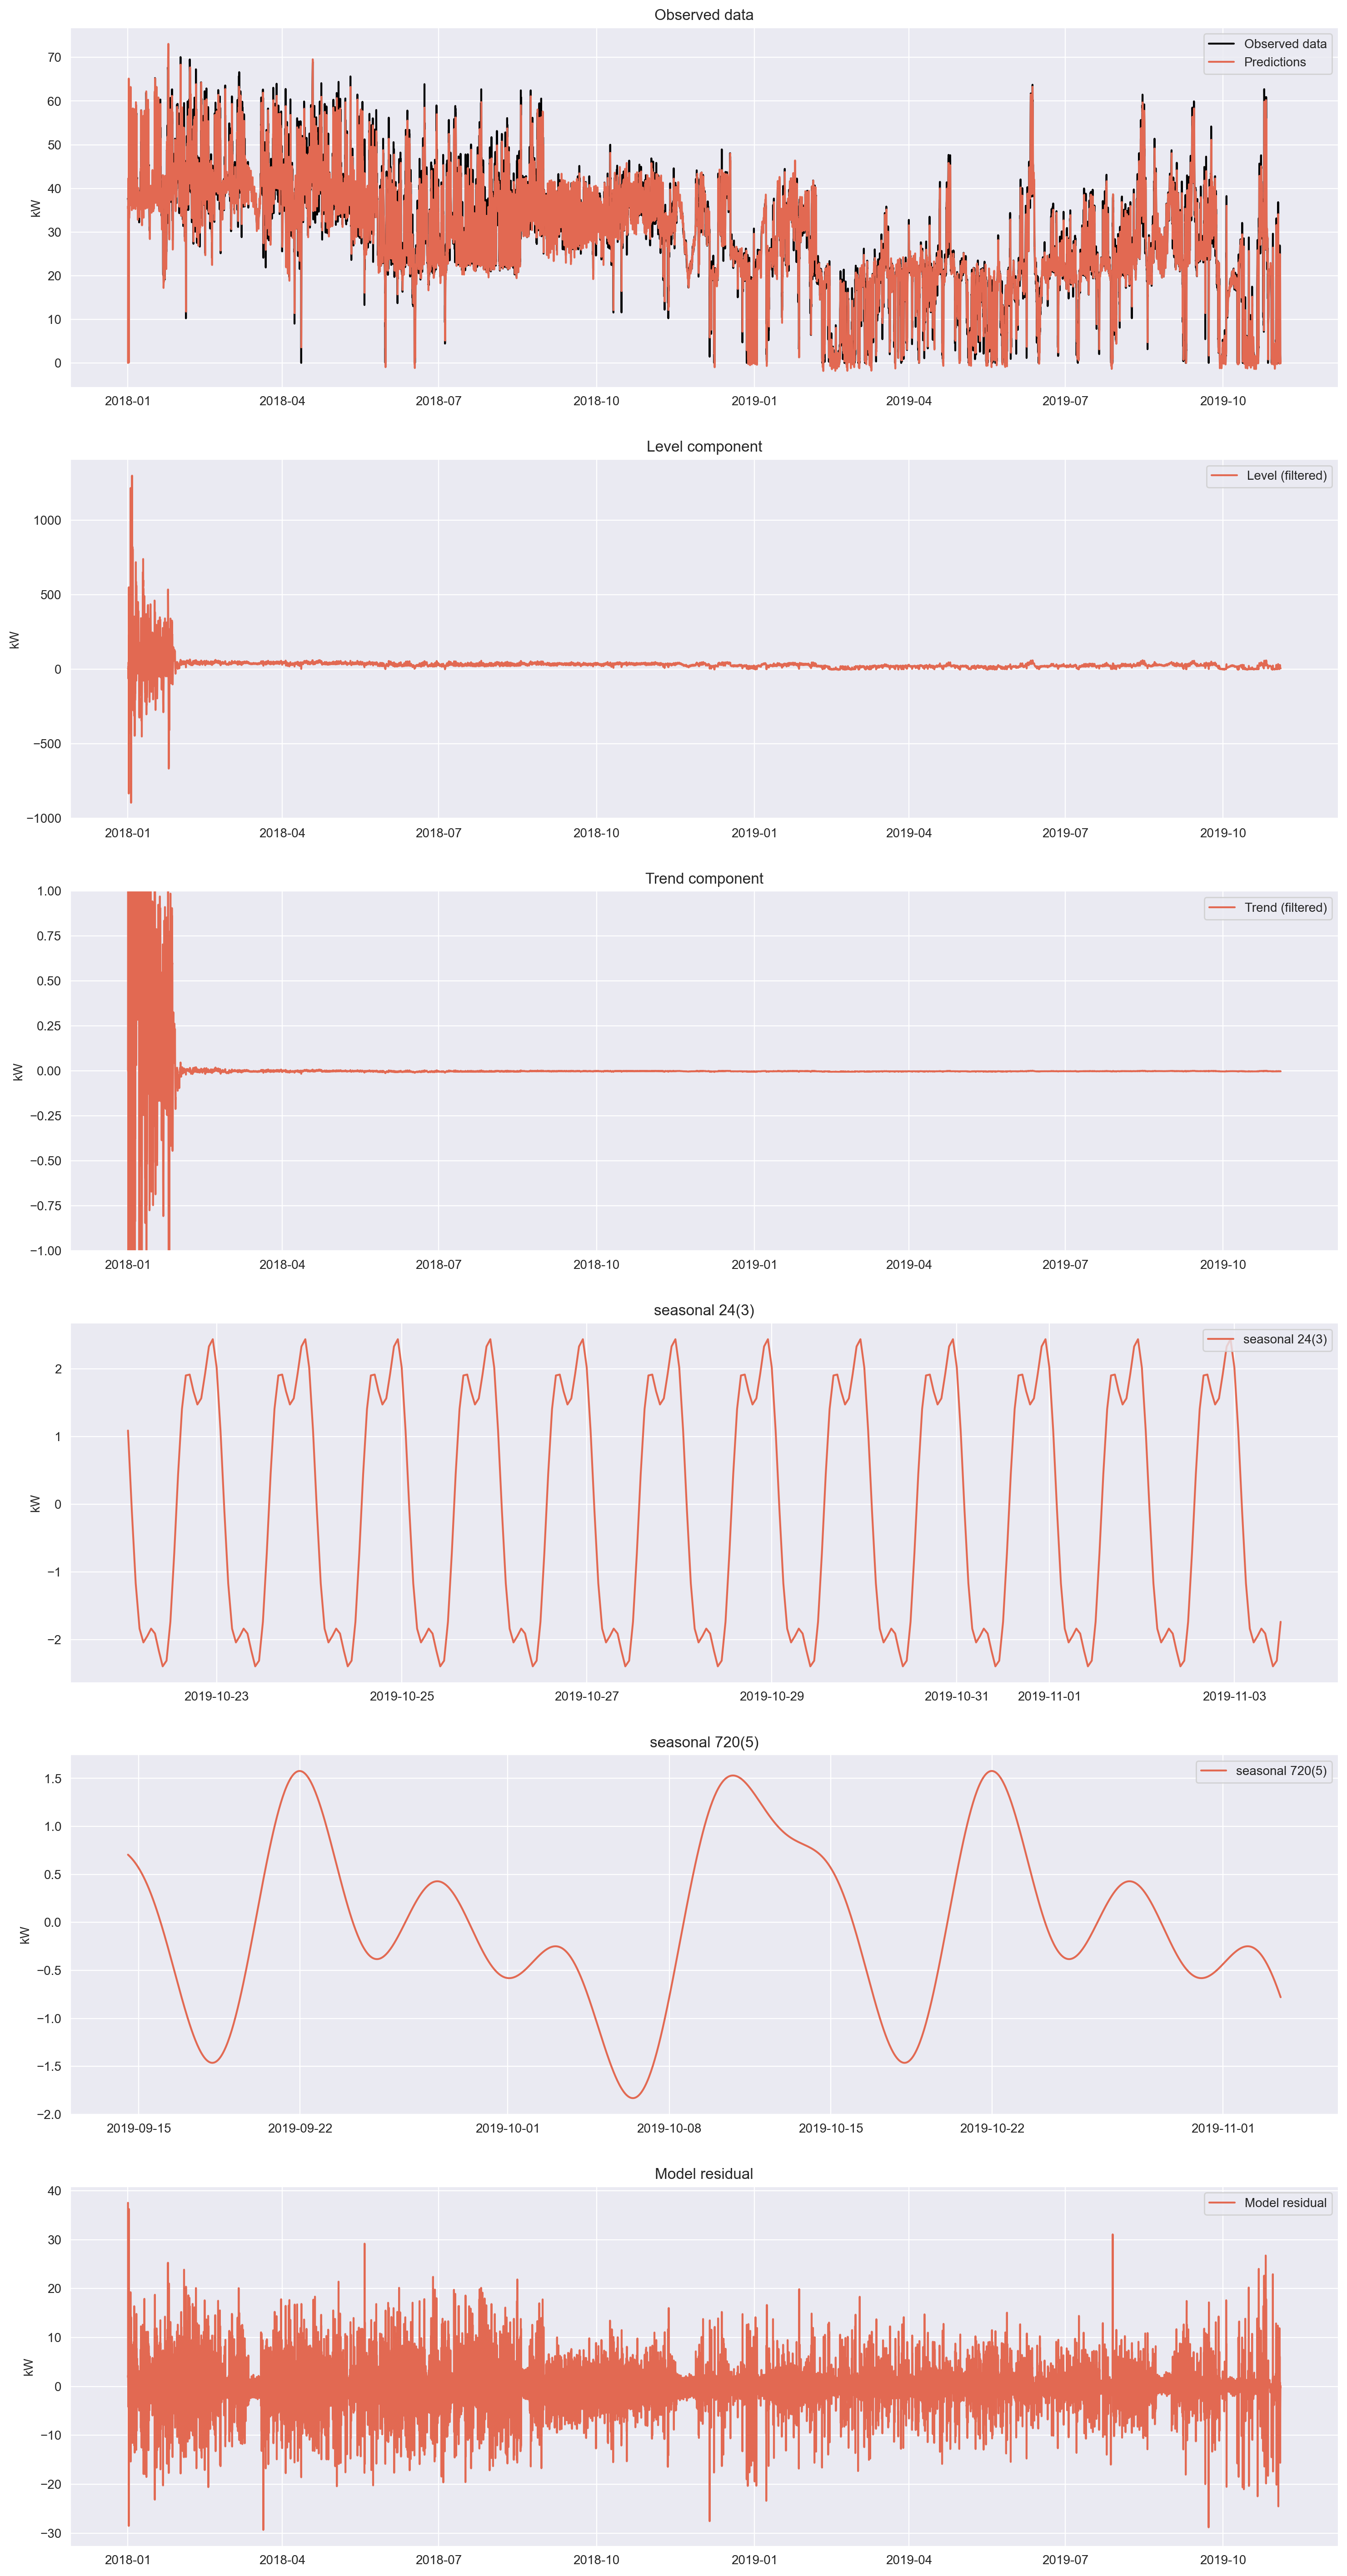

In [57]:
f, axes = plt.subplots(6,1,figsize=(18,36),dpi=200)

#custom plotting of observed train data in style of results class '.plot_components()' method

#plotting observed data
axes[0].plot(df_train_grouped, label='Observed data', color='black')
axes[0].plot(model_UC1res_g.fittedvalues, label='Predictions')
axes[0].legend()

#plotting smoothed level component
axes[1].plot(df_train_grouped.index, model_UC1res_g.level['filtered'], label='Level (filtered)')
axes[1].legend()

#plotting smoothed trend component
axes[2].plot(df_train_grouped.index, model_UC1res_g.trend['filtered'], label='Trend (filtered)')
axes[2].set_ylim(-1,1)
axes[2].legend()

limits = [-300, -1200, 0]

#plotting smoothed seasonal components with arbitrary time window scales
for i in range(3,5,1):
    axes[i].plot(df_train_grouped.index[limits[i-3]:], model_UC1res_g.freq_seasonal[i-3]['smoothed'][limits[i-3]:], label=model_UC1res_g.freq_seasonal[i-3]['pretty_name'])
    axes[i].legend(loc='upper right')

#plotting residuals
axes[5].plot(df_train_grouped.index, model_UC1res_g.resid, label='Model residual')
axes[5].legend()

#list of subplot titles
axtitles = ['Observed data',
            'Level component',
            'Trend component',
            model_UC1res_g.freq_seasonal[0]['pretty_name'],
            model_UC1res_g.freq_seasonal[1]['pretty_name'],
            'Model residual']

#setting y labels and subplot titles (former is missing from '.plot_components()')
for i,a in enumerate(axes):
    a.set_ylabel('kW')
    a.set_title(axtitles[i])

plt.show()

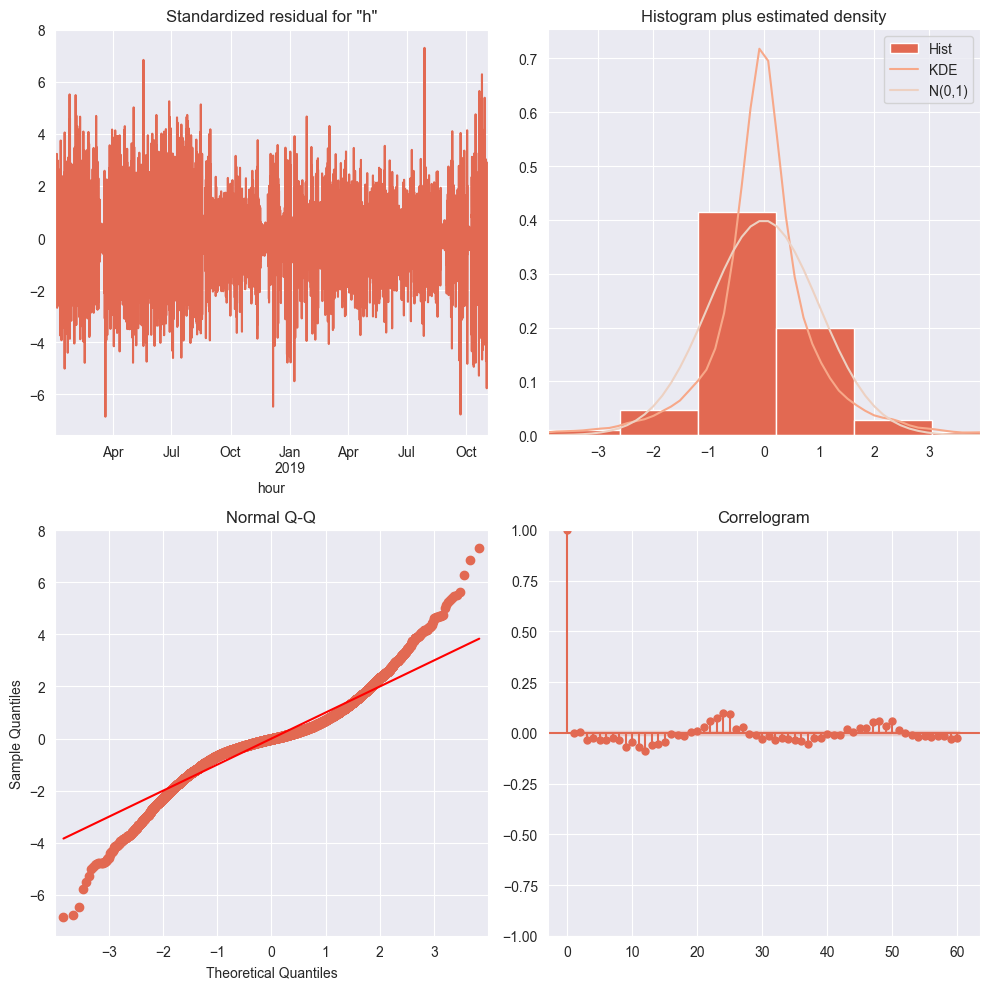

In [58]:
model_UC1res_g.plot_diagnostics(figsize=(10,10),lags=60)
plt.tight_layout()
plt.show()

/Users/maguado/miniconda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


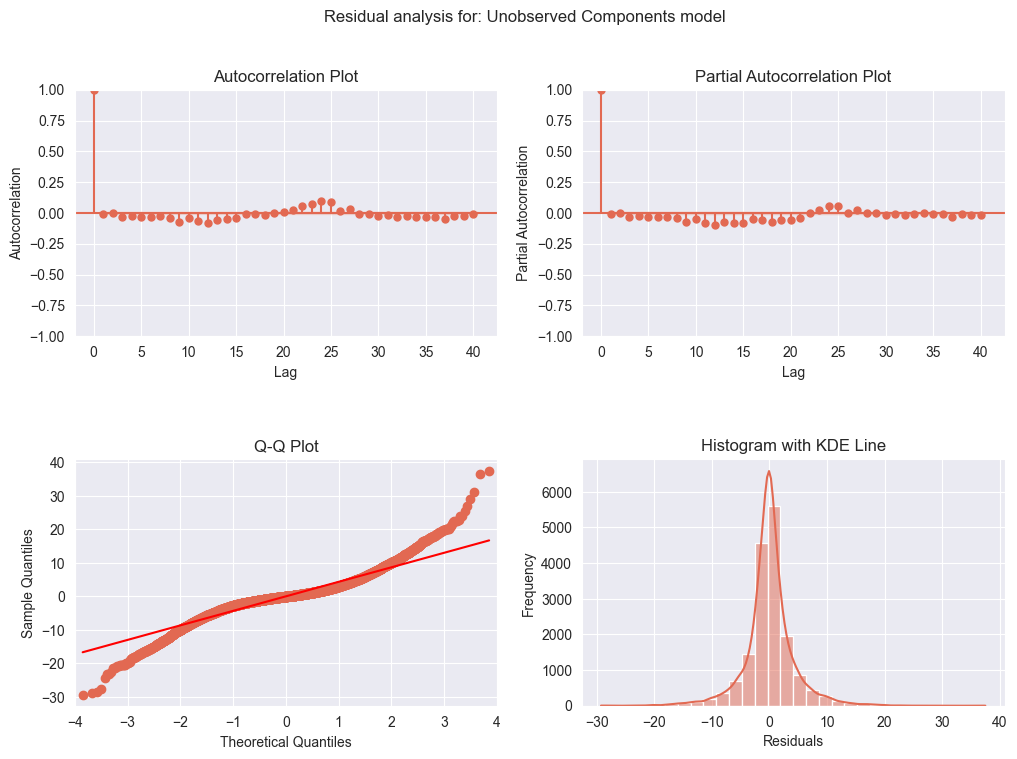

The residuals do not follow a normal distribution (p-value = 0.00000000000000000000, alpha = 0.05)
The residuals are autocorrelated (some p-values < alpha = 0.0500000000)
           lb_stat     lb_pvalue
1         1.101992  2.938294e-01
2         1.106387  5.751103e-01
3        21.418956  8.615649e-05
4        33.250703  1.061303e-06
5        50.156556  1.287244e-09
...            ...           ...
2040  13885.750454  0.000000e+00
2041  13886.242887  0.000000e+00
2042  13890.763731  0.000000e+00
2043  13890.969133  0.000000e+00
2044  13900.415409  0.000000e+00

[2044 rows x 2 columns]
Durbin Watson:  2.011694839855953
No autocorrelation


In [43]:
residual_analysis(model_UC1res_g.resid, title="Unobserved Components model")

In [44]:
df_test_grouped.shape

(2000,)

In [62]:
#Forecasting
forecast_UC1 = model_UC1res_g.forecast(steps=len(df_test_grouped))

In [63]:
len(forecast_UC1)

2843

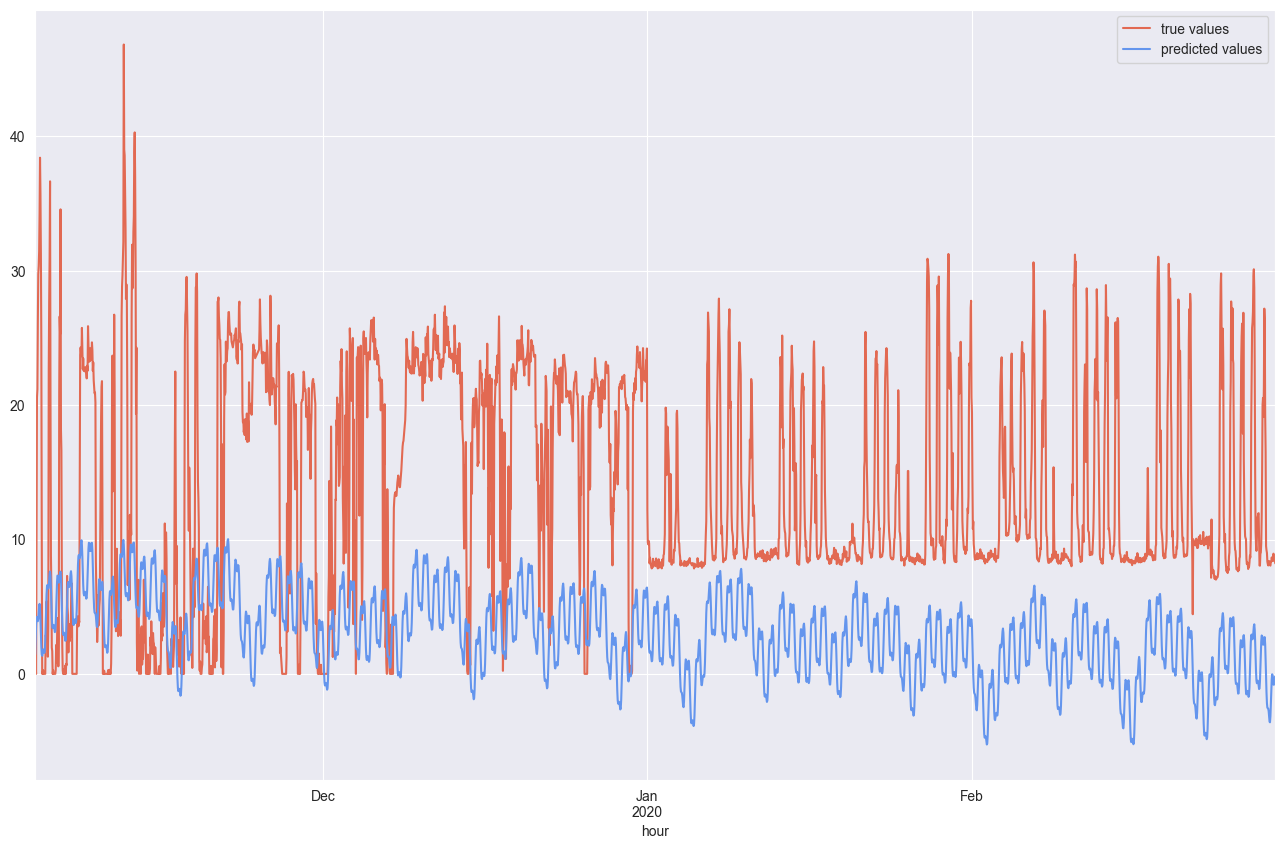

In [64]:

results_UC1 = pd.DataFrame(df_test_grouped)
results_UC1['forecast'] = forecast_UC1

plt.figure(figsize=(16, 10))
df = energy_grouped
#Out of sample forecast
ax = results_UC1[var].plot(label='true values')
results_UC1['forecast'].plot(label='predicted values', ax=ax, color='cornflowerblue')
plt.legend()

In [65]:
metrics2(forecast_UC1, df_test_grouped, "TEST")

TEST SET METRICS
mae: 11.56525927384371
mape: 18.582231217574986
rmse: 13.165326744867794


In [67]:
metrics2(model_UC1res_g.fittedvalues, df_train_grouped, "TRAIN")

TRAIN SET METRICS
mae: 2.831175038239482
mape: 4.087037358467871
rmse: 4.325325248194279


## Complex Exponential Smoothing

In [19]:
from pmdarima.preprocessing import FourierFeaturizer


In [20]:
# prepare Fourier terms
exog = pd.DataFrame({'date': energy_grouped.index})



In [21]:
four_terms = FourierFeaturizer(24*7, 1)
y_prime, exog = four_terms.fit_transform(energy_grouped[var])
exog['date'] = y_prime.index # is exactly the same as manual calculation in the above cells
exog = exog.set_index(exog['date'])
exog.index.freq = 'H'
exog = exog.drop(columns=['date'])


In [25]:
n = len(df_test_grouped)

In [26]:
exog_to_train_grouped = exog.iloc[:-n,:]
exog_to_test_grouped = exog.iloc[-n:, :]


In [27]:
assert exog_to_train_grouped.shape[0] == df_train_grouped.shape[0]

In [28]:
from statsforecast import StatsForecast
from statsforecast.models import AutoCES

sf = AutoCES(season_length = 24)

sf.fit(df_train_grouped.values, exog_to_train_grouped.values)


CES

In [29]:
forecasts = sf.predict(len(df_test_grouped), exog_to_test_grouped.values)['mean']


In [30]:
sf.model_

{'loglik': -101283.62094395587,
 'aic': 202577.24188791175,
 'bic': 202615.67972714332,
 'aicc': 202577.24561230652,
 'mse': 79.79297312030725,
 'amse': 84.28698174922599,
 'fit': results(x=array([1.72536896, 0.99225106, 1.00931529, 1.00000512]), fn=202567.24188791175, nit=179, simplex=array([[1.72543822, 0.99222903, 1.00931515, 1.00000509],
        [1.72534257, 0.9922509 , 1.0093063 , 1.00000652],
        [1.72542883, 0.99226508, 1.00930864, 1.00000621],
        [1.72536896, 0.99225106, 1.00931529, 1.00000512],
        [1.72540674, 0.99225824, 1.00929979, 1.00000579]])),
 'fitted': array([38.04953718, 34.47169337, 36.2958992 , ...,  0.65333889,
         0.22843147,  0.70443472]),
 'residuals': array([-0.52453661,  3.27830759,  1.25410195, ..., -0.64333889,
        -0.21843147, -0.34360139]),
 'm': 24,
 'states': array([[31.332859  , 18.205297  ,  3.2700686 ,  3.2966692 ],
        [31.474611  , 18.293192  ,  0.26669535,  0.26415825],
        [31.616945  , 18.368244  , -0.19179077, -0.1

In [31]:
results = pd.DataFrame(df_test_grouped)
results['forecast']=forecasts

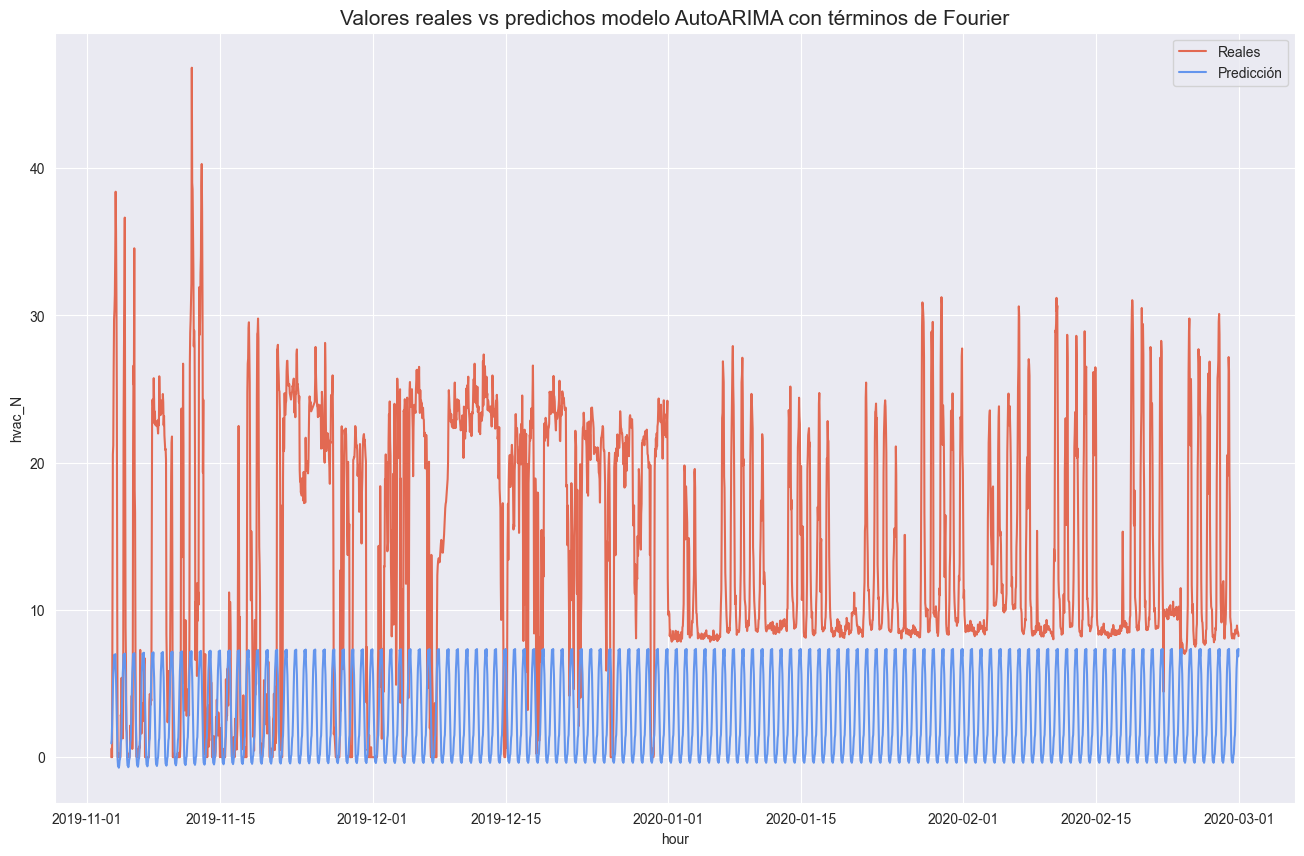

In [32]:
actuals = df_test_grouped
# Plot the forecasts and actual valuesb
plt.figure(figsize=(16, 10))
sns.lineplot(x=results.index, y=results[var], label='Reales')
sns.lineplot(x=results.index, y=results['forecast'], label='Predicción', color='cornflowerblue')

plt.title('Valores reales vs predichos modelo AutoARIMA con términos de Fourier', fontsize=15)
plt.legend()
plt.show()